# Import Packages and Define Functions

In [1]:
# import python embedding from TimsRust
import timsrust_pyo3

from pyteomics import mzml
from psims.transform.mzml import MzMLTransformer, cvstr
from pyteomics.auxiliary import unitfloat
from pyteomics import mgf
from pyteomics import mztab

import os
from typing import Dict, List, Tuple
import fileinput
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def flatten(nested_list):
    """
    Flatten a nested list into a single flat list.

    Parameters:
        nested_list (list): The nested list to be flattened.

    Returns:
        list: The flattened list.
    """
    flattened_list = [item for sublist in nested_list for item in sublist]
    return flattened_list

#dataclass
class DenseFrame:
    rt: float
    intensities: list[int]
    mzs: list[float]
    imss: list[float]

    #classmethod
    def from_frame(
        cls, frame: timsrust_pyo3.PyFrame, reader: timsrust_pyo3.TimsReader
    ):
        mzs = reader.resolve_mzs(frame.tof_indices)
        out_imss = [None] * len(mzs)
        last_so = 0
        for ims, so in zip(
            reader.resolve_scans(list(range(1, len(frame.scan_offsets) + 1))),
            frame.scan_offsets,
            strict=True,
        ):
            out_imss[last_so:so] = [ims] * (so - last_so)
            last_so = so

        return cls(
            rt=frame.rt,
            intensities=frame.intensities,
            mzs=mzs,
            imss=out_imss,
        )

class Precursor:
    mz: float
    rt: float
    im: float
    charge: int
    intensity: float
    index: int
    frame_index: int
    collision_energy: float

    #classmethod
    def from_precursor(cls, precursor, reader):
        mz = reader.resolve_mzs(frame.tof_indices)
        rt = frame.rt
        im = 0.0  # Placeholder value, replace with actual logic
        charge = 0  # Placeholder value, replace with actual logic
        intensity = 0.0  # Placeholder value, replace with actual logic
        index = 0  # Placeholder value, replace with actual logic
        frame_index = 0  # Placeholder value, replace with actual logic
        collision_energy = 0.0  # Placeholder value, replace with actual logic

        return cls(
            mz=mz,
            rt=rt,
            im=im,
            charge=charge,
            intensity=intensity,
            index=index,
            frame_index=frame_index,
            collision_energy=collision_energy,
        )

def in_minutes(x):
    '''Convert a time quantity to minutes

    Parameters
    ----------
    x: unitfloat
        A float representing a quantity of time annotated with a time unit

    Returns
    -------
    unitfloat:
        The time after conversion to minutes
    '''
    try:
        unit = x.unit_info
    except AttributeError:
        return x
    if unit == 'minute':
        return x
    elif unit == 'second':
        y = unitfloat(x / 60., 'minute')
        return y
    elif unit == 'hour':
        y = unitfloat(x * 60, 'minute')
        return y
    else:
        warnings.warn("Time unit %r not recognized" % unit)
    return x

def in_seconds(x):
    '''Convert a time quantity to seconds

    Parameters
    ----------
    x: unitfloat
        A float representing a quantity of time annotated with a time unit

    Returns
    -------
    unitfloat:
        The time after conversion to seconds
    '''
    try:
        unit = x.unit_info
    except AttributeError:
        return x
    if unit == 'second':
        return x
    elif unit == 'minute':
        y = unitfloat(x * 60., 'second')
        return y
    elif unit == 'hour':
        y = unitfloat(x * 3600, 'second')
        return y
    else:
        warnings.warn("Time unit %r not recognized" % unit)
    return x

# Retrieve spectra data

In [2]:
path = "/Users/daviddornig/miniconda3/envs/casanovo_env/lib/python3.10/site-packages/Casaval/Testing/example_data/5909_HeLa200ng_1hour_9-14-2023.d"
reader = timsrust_pyo3.TimsReader(path)

In [3]:
TR_all_spectra = reader.read_all_spectra()

In [4]:
TR_spectra_1 = TR_all_spectra[0]

In [5]:
TR_precursor_1 = TR_all_spectra[0].precursor

In [6]:
TR_all_spectra[0]

PySpectrum(index=0, len(mz_values)=67, len(intensities)=67, precursor=(index=1, frame_index=8, mz=663.2879991882091, im=0.8166844415024028, charge=2, intensity=1777))

In [7]:
TR_precursor_1.mz

663.2879991882091

In [8]:
reader.read_spectrum(index=0)

PySpectrum(index=0, len(mz_values)=67, len(intensities)=67, precursor=(index=1, frame_index=8, mz=663.2879991882091, im=0.8166844415024028, charge=2, intensity=1777))

In [9]:
TR_spectra_1

PySpectrum(index=0, len(mz_values)=67, len(intensities)=67, precursor=(index=1, frame_index=8, mz=663.2879991882091, im=0.8166844415024028, charge=2, intensity=1777))

In [10]:
mz_list = TR_all_spectra[0].mz_values
print(mz_list)

[273.03466354161986, 360.92334212510104, 400.35373277781986, 401.8133103861163, 407.28968561994867, 411.9606209715564, 419.3447774187975, 428.82073145081455, 431.31027364990433, 435.3131368165745, 435.7279407249644, 436.30438496747695, 441.2709076625036, 443.3078997274028, 456.35934079821664, 459.2823697135421, 461.80106136935785, 462.31308821225906, 462.7812813889207, 463.31761960345636, 469.82235562601835, 471.3759916106486, 476.8339136909532, 479.89080257934086, 482.6247081534055, 484.8695263286511, 486.3399744023621, 486.8027739148428, 486.8306184970462, 492.8602086197886, 497.2334970551532, 507.8885452440419, 512.2778749444939, 516.2773941641501, 516.3275761830735, 519.9219113950902, 522.349096619367, 522.4500515243793, 526.9053457203823, 528.7936004552736, 535.3469621998132, 538.8566375378165, 540.8322005116535, 545.0335273609973, 551.8717282692417, 562.7009303653501, 566.3628281289388, 566.8434653915355, 567.3430935046222, 571.7478025801689, 573.9829994640005, 628.5522275047583,

In [11]:
TR_all_frames = reader.read_all_frames()

In [12]:
TR_all_frames_indexcorrected = {}

for frame in TR_all_frames:
    TR_all_frames_indexcorrected[frame.index] = frame

In [13]:
TR_all_frames_indexcorrected[1]

PyFrame(index=1, rt=0.639134, frame_type=0, len(scan_offsets)=928, len(tof_indices)=48951, len(intensities)=48951)

# Inspect provided mzml files with pyteomics

In [14]:
mzml_file = '/Users/daviddornig/miniconda3/envs/casanovo_env/lib/python3.10/site-packages/Casaval/Testing/example_data/5909_HeLa200ng_1hour_9-14-2023.mzml'

In [15]:
with mzml.read(mzml_file) as mzml_data:
    for spectrum in mzml_data:
        # Access spectrum attributes
        mz_values = spectrum['m/z array']
        intensity_values = spectrum['intensity array']
        retention_time = spectrum['scanList']['scan'][0]['scan start time']



In [16]:
with mzml.read(mzml_file) as mzml_data:
    # Initialize an empty dictionary to store spectra data
    MZML_spectra_data = {}

    # Iterate over spectra in the mzML file
    for spectrum in mzml_data:
        # Get spectrum ID
        spectrum_id = spectrum['index']

        # Store spectrum data in the dictionary
        MZML_spectra_data[spectrum_id] = {
            'mz_values': spectrum['m/z array'],
            'intensity_values': spectrum['intensity array'],
            'retention_time': spectrum['scanList']['scan'][0]['scan start time'],
            'ion_mobility': spectrum['total ion current']
        }

In [17]:
with mzml.read(mzml_file) as mzml_data:
    # Initialize an empty dictionary to store spectra data
    MZML_spectra_data_detailed = {}

    # Iterate over spectra in the mzML file
    for index, spectrum in enumerate(mzml_data):
        # Store spectrum data in the dictionary
        MZML_spectra_data_detailed[index] = spectrum
            

In [18]:
limit = 10
count = 0
for count in MZML_spectra_data_detailed:
    if count <= limit:
        print(MZML_spectra_data_detailed[count])
    else:
        break

{'index': 0, 'defaultArrayLength': 17373, 'id': 'index=1', 'scanList': {'count': 1, 'scan': [{'scanWindowList': {'count': 1, 'scanWindow': [{'scan window lower limit': 100.0, 'scan window upper limit': 1700.0}]}, 'scan start time': 0.010652233333333334}], 'no combination': ''}, 'ms level': 1, 'total ion current': 4758905.0, 'base peak intensity': 115579.0, 'base peak m/z': 1221.9882233393096, 'positive scan': '', 'centroid spectrum': '', 'MS1 spectrum': '', 'count': 2, 'm/z array': array([ 100.57569506,  101.09210999,  101.36510722, ..., 1698.5229779 ,
       1699.56335017, 1699.85601226]), 'intensity array': array([102.,  66.,  67., ..., 101., 122.,  87.], dtype=float32)}
{'index': 1, 'defaultArrayLength': 17444, 'id': 'index=2', 'scanList': {'count': 1, 'scan': [{'scanWindowList': {'count': 1, 'scanWindow': [{'scan window lower limit': 100.0, 'scan window upper limit': 1700.0}]}, 'scan start time': 0.012646316666666666}], 'no combination': ''}, 'ms level': 1, 'total ion current': 477

# Write a .mzML file corresponding to provided data !incomplete! (complete data conversion better with ProteoWizard msconvert?)

## Compare the file keys

In [19]:
TR_all_spectra[0]

PySpectrum(index=0, len(mz_values)=67, len(intensities)=67, precursor=(index=1, frame_index=8, mz=663.2879991882091, im=0.8166844415024028, charge=2, intensity=1777))

In [20]:
MZML_spectra_data_detailed[0].keys()

dict_keys(['index', 'defaultArrayLength', 'id', 'scanList', 'ms level', 'total ion current', 'base peak intensity', 'base peak m/z', 'positive scan', 'centroid spectrum', 'MS1 spectrum', 'count', 'm/z array', 'intensity array'])

In [21]:
MZML_spectra_data_detailed[8] 

{'index': 8,
 'defaultArrayLength': 67,
 'id': 'index=9',
 'scanList': {'count': 1,
  'scan': [{'scanWindowList': {'count': 1,
     'scanWindow': [{'scan window lower limit': 100.0 m/z,
       'scan window upper limit': 1700.0 m/z}]},
    'scan start time': 0.025463799999999998 minute}],
  'no combination': ''},
 'precursorList': {'count': 1,
  'precursor': [{'spectrumRef': 'index=8',
    'isolationWindow': {'isolation window target m/z': 663.2879991882091 m/z,
     'isolation window lower offset': 0.5917277272992578 m/z,
     'isolation window upper offset': 1.4082722727007422 m/z},
    'selectedIonList': {'count': 1,
     'selectedIon': [{'selected ion m/z': 663.2879991882091 m/z,
       'charge state': 2,
       'inverse reduced ion mobility': 0.8293334816068573 volt-second per square centimeter}]},
    'activation': {'collision energy': 33.38565022421525 electronvolt,
     'CID': ''}}]},
 'ms level': 2,
 'total ion current': 5412.0,
 'positive scan': '',
 'centroid spectrum': '',
 

Provided mzML file has a lot of more parameters for reproducible and comparable ms data:
1. spectrum index (index (counted from 0), id (counted from 1))
2. defaultArrayLength - Length of mz Arrays
3. scanList provides scanData (scan window lower limit, upper limit, scan start time, no combination)
4. ms level
5. total ion current
6. base peak intensity
7. base peak m/z
8. positive scan
9. centroid spectrum
10. MS1 spectrum
11. count
12. m/z array
13. intensity array
    
If a precursor exists, there is additionally:

15. precursor list with count, and precursor - data: [spectrum index, isolationWindow (with m/z), offsets from window]
16. selection ion list with count and activation data: [energy, CID], and ion - data: [ion m/z, ion charge, inversed ion mobility]

# Casanovo prefers .mgf, .h5, .hdf5 files for training

For example their own provided .mgf file:

In [22]:
path = "/Users/daviddornig/miniconda3/envs/casanovo_env/lib/python3.10/site-packages/Casaval/Testing/example_data/sample_preprocessed_spectra.mgf"

In [23]:
from pyteomics import mgf

# Dictionary to store spectra
example_spectra_dict = {}

# Open the MGF file and iterate through spectra
with mgf.read(path) as spectra:
    for index, spectrum in enumerate(spectra):
        example_spectra_dict[index] = spectrum 

## Parameter dictionary structure comparison (TimsRust and example mgf)

In [24]:
example_spectra_dict[0]

{'params': {'title': '0',
  'pepmass': (451.25348, None),
  'charge': [2],
  'scans': 'F1:2478',
  'rtinseconds': 824.574 second,
  'seq': 'IAHYNKR'},
 'm/z array': array([ 63.9948349 ,  70.06543732,  84.08129883,  85.08439636,
         86.09666443, 110.0710907 , 129.102005  , 138.065979  ,
        157.13291931, 175.11853027, 185.12837219, 209.10263062,
        273.13378906, 301.1282959 , 303.21221924, 304.17529297,
        322.18591309, 350.67874146, 417.25521851, 580.31854248,
        630.36572266, 717.37670898, 753.37487793, 788.42077637,
        866.45446777]),
 'intensity array': array([0.06119308, 0.06860413, 0.22455615, 0.06763621, 0.22344913,
        0.30348614, 0.09322319, 0.07667152, 0.14716865, 0.19198035,
        0.09717457, 0.13139844, 0.09324287, 0.08515828, 0.07235292,
        0.07120858, 0.1583406 , 0.07397215, 0.1498218 , 0.31572264,
        0.06255879, 0.59908968, 0.09976937, 0.35858697, 0.12016355]),
 'charge array': masked_array(data=[--, --, --, --, --, --, --, --,

In [25]:
type(example_spectra_dict[0]['params']['rtinseconds'])

pyteomics.auxiliary.structures.unitfloat

In [26]:
TR_all_spectra[0] 
#invoke parameters with .mz_values, .intensities, .precursor, .im, .charge, .intensity per precursor

PySpectrum(index=0, len(mz_values)=67, len(intensities)=67, precursor=(index=1, frame_index=8, mz=663.2879991882091, im=0.8166844415024028, charge=2, intensity=1777))

In [27]:
TR_all_frames[7]

PyFrame(index=8, rt=1.527828, frame_type=0, len(scan_offsets)=928, len(tof_indices)=48758, len(intensities)=48758)

# Convert TimsRust dictionary to .mgf

## Define placeholder dict:

In [28]:
from pyteomics.auxiliary import unitfloat
from typing import Dict, List, Tuple

# Define the placeholder dictionary with specified data types
TR_to_mgf_spectrum_dict: Dict[str, Dict[str, object]] = {
    'params': {
        'title': str, # File name: Precursor Index
        'pepmass': Tuple[float, float],
        'charge': List[int],
        'ion_mobility': float,
        'scans': str,
        'rtinseconds': unitfloat, # pyteomics own datatype for values with units
        'casanovo_seq': str, # For later evaluation, the added casanovo prediction seq
        'seq': str # Database sequence as 'seq' to keep casanovo's definition of this parameter
    },
    'm/z array': List[float],
    'intensity array': List[float]
}

In [29]:
# Example:
TR_to_mgf_spectrum_dict['params']['title'] = 'HeLa:0' # Precursor Index
TR_to_mgf_spectrum_dict['params']['pepmass'] = (500.0, 1.0)
TR_to_mgf_spectrum_dict['params']['charge'] = [1]
TR_to_mgf_spectrum_dict['params']['ion_mobility'] = 0.0
TR_to_mgf_spectrum_dict['params']['scans'] = 'F1' # Frame/Scan Index
TR_to_mgf_spectrum_dict['params']['rtinseconds'] = unitfloat(10.0, 'second')
TR_to_mgf_spectrum_dict['params']['casanovo_seq'] = 'ACDEFGH'
TR_to_mgf_spectrum_dict['params']['seq'] = 'ABCDEFGHIJ'
TR_to_mgf_spectrum_dict['m/z array'] = [100.0, 200.0, 300.0]
TR_to_mgf_spectrum_dict['intensity array'] = [10.0, 20.0, 30.0]

print(TR_to_mgf_spectrum_dict)

{'params': {'title': 'HeLa:0', 'pepmass': (500.0, 1.0), 'charge': [1], 'ion_mobility': 0.0, 'scans': 'F1', 'rtinseconds': 10.0, 'casanovo_seq': 'ACDEFGH', 'seq': 'ABCDEFGHIJ'}, 'm/z array': [100.0, 200.0, 300.0], 'intensity array': [10.0, 20.0, 30.0]}


## Define class type for a spectrum in mgf:

In [30]:
class TR_to_MGF_Spectrum:
    def __init__(self, title: str, pepmass: Tuple[float, float], charge: List[int], ion_mobility: float, scans: str, rtinseconds: unitfloat, casanovo_seq: str, casanovo_aa_scores: List[float], seq: str, mz_array: List[float], intensity_array: List[float]):
        self.params = {
            'title': title,
            'pepmass': pepmass,
            'charge': charge,
            'ion_mobility': ion_mobility,
            'scans': scans,
            'rtinseconds': rtinseconds,
            'casanovo_seq': casanovo_seq,
            'casanovo_aa_scores': [],
            'seq': seq
        }
        self.mz_array = mz_array
        self.intensity_array = intensity_array

    def to_dict(self) -> dict:
        return {
            'params': self.params,
            'm/z array': self.mz_array,
            'intensity array': self.intensity_array
        }


In [31]:
spectrum = TR_to_MGF_Spectrum(
    title='Precursor Index',
    pepmass=(500.0, 1.0),
    charge=[1],
    ion_mobility=1.0,
    scans='Scan1',
    rtinseconds=unitfloat(10.0, 'second'),
    casanovo_seq='',
    casanovo_aa_scores = [],
    seq='',
    mz_array=[100.0, 200.0, 300.0],
    intensity_array=[10.0, 20.0, 30.0]
)

In [32]:
spectrum.to_dict()

{'params': {'title': 'Precursor Index',
  'pepmass': (500.0, 1.0),
  'charge': [1],
  'ion_mobility': 1.0,
  'scans': 'Scan1',
  'rtinseconds': 10.0 second,
  'casanovo_seq': '',
  'casanovo_aa_scores': [],
  'seq': ''},
 'm/z array': [100.0, 200.0, 300.0],
 'intensity array': [10.0, 20.0, 30.0]}

# Convert TimsRust retrieved data to a list of mgf ready spectra dictionaries

## Call example data of the first precursor of HeLa for inspection of available metadata

In [33]:
TR_all_spectra[0]

PySpectrum(index=0, len(mz_values)=67, len(intensities)=67, precursor=(index=1, frame_index=8, mz=663.2879991882091, im=0.8166844415024028, charge=2, intensity=1777))

In [34]:
frame_index = TR_all_spectra[0].precursor.frame_index

print(TR_all_frames[frame_index])
print(TR_all_frames_indexcorrected[frame_index])

PyFrame(index=9, rt=1.655497, frame_type=1, len(scan_offsets)=928, len(tof_indices)=9, len(intensities)=9)
PyFrame(index=8, rt=1.527828, frame_type=0, len(scan_offsets)=928, len(tof_indices)=48758, len(intensities)=48758)


In [35]:
MZML_spectra_data_detailed[8]

{'index': 8,
 'defaultArrayLength': 67,
 'id': 'index=9',
 'scanList': {'count': 1,
  'scan': [{'scanWindowList': {'count': 1,
     'scanWindow': [{'scan window lower limit': 100.0 m/z,
       'scan window upper limit': 1700.0 m/z}]},
    'scan start time': 0.025463799999999998 minute}],
  'no combination': ''},
 'precursorList': {'count': 1,
  'precursor': [{'spectrumRef': 'index=8',
    'isolationWindow': {'isolation window target m/z': 663.2879991882091 m/z,
     'isolation window lower offset': 0.5917277272992578 m/z,
     'isolation window upper offset': 1.4082722727007422 m/z},
    'selectedIonList': {'count': 1,
     'selectedIon': [{'selected ion m/z': 663.2879991882091 m/z,
       'charge state': 2,
       'inverse reduced ion mobility': 0.8293334816068573 volt-second per square centimeter}]},
    'activation': {'collision energy': 33.38565022421525 electronvolt,
     'CID': ''}}]},
 'ms level': 2,
 'total ion current': 5412.0,
 'positive scan': '',
 'centroid spectrum': '',
 

## Prepare for saving TR data to mgf format:

### Get file specifications:

In [36]:
import os

file_path = "/Users/daviddornig/Documents/SoftwareProject/5909_HeLa200ng_1hour_9-14-2023.d"
file_name = os.path.basename(file_path)
file_name_without_extension = os.path.splitext(os.path.basename(file_path))[0]
file_extension = os.path.splitext(os.path.basename(file_path))[1]

print(file_name_without_extension)  # Output: 5909_HeLa200ng_1hour_9-14-2023.d

5909_HeLa200ng_1hour_9-14-2023


In [37]:
example_title = f'{TR_all_spectra[0].precursor.index}'
example_split = example_title.split(':')
example_split

['1']

### Structure TR spectra as mgf spectra:

In [38]:
TR_to_mgf_spectra_list = []
for spectrum in TR_all_spectra:
    spectrum_instance = TR_to_MGF_Spectrum(
        title=spectrum.precursor.index,
        #f'{file_name_without_extension}:Precursor_{spectrum.precursor.index}'
        pepmass=(spectrum.precursor.mz, None),
        charge=[spectrum.precursor.charge],
        ion_mobility=spectrum.precursor.im,
        scans=f'F{spectrum.precursor.frame_index}:{spectrum.precursor.intensity}',
        rtinseconds=unitfloat(TR_all_frames_indexcorrected[spectrum.precursor.frame_index].rt, 'second'),
        casanovo_seq='',
        casanovo_aa_scores=[],
        seq='',
        mz_array=spectrum.mz_values,
        intensity_array=spectrum.intensities
    )
    TR_to_mgf_spectra_list.append(spectrum_instance.to_dict())


In [39]:
example_rt = in_minutes(unitfloat(TR_all_frames_indexcorrected[spectrum.precursor.frame_index].rt, 'second'))
example_rt

59.92563591666667 minute

In [40]:
len(TR_to_mgf_spectra_list)

151503

In [41]:
TR_to_mgf_spectra_list[700]

{'params': {'title': 701,
  'pepmass': (1147.9568944899602, None),
  'charge': [2],
  'ion_mobility': 1.11599490046092,
  'scans': 'F3531:4750.0',
  'rtinseconds': 423.862084 second,
  'casanovo_seq': '',
  'casanovo_aa_scores': [],
  'seq': ''},
 'm/z array': [528.1771000505856, 987.4026703653274, 1322.586725143252],
 'intensity array': [78.0, 60.0, 31.0]}

## Save as .mgf file:

In [42]:
from pyteomics import mgf

mgf.write(TR_to_mgf_spectra_list, 'output.mgf')

# Inspection: Functions to open and write .mgf files for predictions:

## Read MGF file:

In [43]:
# Read the MGF file and create Spectrum objects
mgf_path = 'output.mgf'
opened_MGF_spectra = mgf.read(mgf_path, convert_arrays=True)

In [44]:
opened_MGF_spectra['151502']

{'params': {'title': '151502',
  'pepmass': (1221.9879333107788, None),
  'rtinseconds': 3589.934304 second,
  'charge': [1],
  'ion_mobility': '1.3690286963761604',
  'scans': 'F33121:50923.0',
  'casanovo_seq': '',
  'casanovo_aa_scores': '[]',
  'seq': ''},
 'm/z array': array([ 248.91790045,  250.92294504,  277.92815861,  318.17916291,
         346.00916032,  391.9424282 ,  510.17348558,  533.94265766,
         553.93781316,  553.94895153,  715.94391359,  715.95657642,
         715.96501836,  716.92772652,  716.96996537,  744.43020118,
         857.943003  ,  858.95521006,  877.9499306 ,  877.96862731,
         878.9458073 ,  878.95983776,  898.94877819,  899.96595563,
         969.95756987, 1039.95854862, 1039.99924635, 1040.02468284,
        1040.96096197, 1040.98641022, 1042.9010096 , 1220.5052228 ,
        1220.64300403, 1221.56358216, 1221.75656168, 1221.93301343,
        1221.97712836, 1221.99918613, 1222.01021508, 1222.02124409,
        1222.04330225, 1222.1646257 , 1222.887

## Load prediction data

In [45]:
import pandas as pd
from pyteomics import mztab

### load database predictions:

In [46]:
database_path = '../Casaval/Testing/example_data/5909_HeLa200ng_1hour_9-14-2023-database_predictions.csv'

database_df_origin = pd.read_csv(database_path)

In [47]:
database_df_origin = database_df_origin.sort_values(by='Precursor Id', ascending=True)
database_df_origin

,Peptide,-10lgP,Mass,Length,ppm,m/z,RT,1/k0 Range,Area HeLa200ng,Fraction,Precursor Id,Source File,#Feature,#Feature HeLa200ng,Accession,PTM,AScore,Found By
22345,HAVSEGTK,53.98,827.4137,8,-2.3,414.7132,3.83,0.7669-0.7954,0.0,1,251,5909_HeLa200ng_1hour_9-14-2023.d,0,0,Q99880|H2B1L_HUMAN:O60814|H2B1K_HUMAN:P58876|H...,NaN,NaN,PEAKS DB
36749,KTESHHK,31.98,865.4406,7,-3.2,433.7262,5.86,0.7430-0.7715,0.0,1,339,5909_HeLa200ng_1hour_9-14-2023.d,0,0,Q6FI13|H2A2A_HUMAN:Q99878|H2A1J_HUMAN:Q96KK5|H...,NaN,NaN,PEAKS DB
26963,RGNVAGDSK,47.92,902.4570,9,-5.4,452.2333,6.97,0.7692-0.7977,0.0,1,387,5909_HeLa200ng_1hour_9-14-2023.d,0,0,P68104|EF1A1_HUMAN,NaN,NaN,PEAKS DB
14713,VSDSGSHSGSDSHSGASR,64.05,1715.7095,18,-6.0,572.9070,6.99,0.8249-0.8533,0.0,1,410,5909_HeLa200ng_1hour_9-14-2023.d,0,0,Q96N21-2|AP4AT_HUMAN:Q96N21|AP4AT_HUMAN,NaN,NaN,PEAKS DB
38847,HGEAQVK,27.22,767.3926,7,-5.8,384.7014,6.99,0.7556-0.7840,0.0,1,423,5909_HeLa200ng_1hour_9-14-2023.d,0,0,P18669|PGAM1_HUMAN,NaN,NaN,PEAKS DB
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17755,A(+42.01)ALDSLSLFTSLGLSEQK,59.94,1921.0044,18,-7.1,961.5026,56.35,1.2753-1.3031,0.0,1,151080,5909_HeLa200ng_1hour_9-14-2023.d,0,0,P47897|SYQ_HUMAN,Acetylation (N-term),A1:Acetylation (N-term):1000.00,PEAKS DB
24526,M(+42.01)ELITILEK,51.19,1130.6257,9,-5.3,566.3171,56.47,0.8918-0.9201,1682.9,1,151090,5909_HeLa200ng_1hour_9-14-2023.d,1,1,Q14974|IMB1_HUMAN,Acetylation (N-term),M1:Acetylation (N-term):1000.00,PEAKS DB
19022,FQSSAVMALQEASEAYLVGLFEDTNLC(+57.02)AIHAK,58.27,3512.6956,32,-4.9,1171.9000,56.46,1.1326-1.1606,0.0,1,151105,5909_HeLa200ng_1hour_9-14-2023.d,0,0,Q71DI3|H32_HUMAN,Carbamidomethylation,C27:Carbamidomethylation:1000.00,PEAKS DB
6627,ELDRDTVFALVNYIFFK,77.35,2089.0884,17,6.5,697.3746,56.48,0.9495-0.9777,0.0,1,151120,5909_HeLa200ng_1hour_9-14-2023.d,0,0,P01009-2|A1AT_HUMAN,NaN,NaN,PEAKS DB


### load casanovo predictions:

In [48]:
casanovo_path = '../Casaval/Testing/example_data/5909_HeLa200ng_1hour_9-14-2023-casanovo_predictions/casanovo_20240106003148.mztab'

file = mztab.MzTab(casanovo_path)
casanovo_df_origin = pd.DataFrame(file.spectrum_match_table)

In [49]:
casanovo_df_origin['Precursor Id'] = casanovo_df_origin['spectra_ref'].str.extract(r'scan=(\d+)', expand=False).astype(int)
# add column for Precursor Id

In [50]:
casanovo_df_origin

,sequence,PSM_ID,accession,unique,database,database_version,search_engine,search_engine_score[1],modifications,retention_time,charge,exp_mass_to_charge,calc_mass_to_charge,spectra_ref,pre,post,start,end,opt_ms_run[1]_aa_scores,Precursor Id
PSM_ID,,,,,,,,,,,,,,,,,,,,
1,TLHTLLLDNRK,1,None,None,None,None,"(Casanovo, 4.0.1)",-0.596066,None,None,2.0,663.28800,662.390785,ms_run[1]:scan=1,None,None,None,None,"0.62897,0.46597,0.40492,0.38024,0.31451,0.3153...",1
2,NDLLLEKEEK,2,None,None,None,None,"(Casanovo, 4.0.1)",-0.652129,None,None,1.0,1221.99000,1230.657608,ms_run[1]:scan=2,None,None,None,None,"0.48481,0.22510,0.24477,0.27449,0.28019,0.3035...",2
3,KPREC+57.021ESC+57.021R,3,None,None,None,None,"(Casanovo, 4.0.1)",-0.650732,None,None,1.0,1223.99230,1221.546302,ms_run[1]:scan=3,None,None,None,None,"0.44714,0.24382,0.22875,0.23995,0.36384,0.2729...",3
4,PMGLLRLK,4,None,None,None,None,"(Casanovo, 4.0.1)",-0.479740,None,None,1.0,922.00525,927.580820,ms_run[1]:scan=4,None,None,None,None,"0.70436,0.43039,0.47188,0.53315,0.39718,0.4157...",4
5,LNNNN,5,None,None,None,None,"(Casanovo, 4.0.1)",-0.803877,None,None,1.0,466.81647,588.273613,ms_run[1]:scan=23,None,None,None,None,"0.21670,0.21841,0.22674,0.20244,0.21438",23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149272,HDC+57.021DK,149272,None,None,None,None,"(Casanovo, 4.0.1)",-0.635977,None,None,1.0,623.02484,674.256251,ms_run[1]:scan=151499,None,None,None,None,"0.32813,0.38435,0.62690,0.32973,0.33301",151499
149273,EC+57.021FER,149273,None,None,None,None,"(Casanovo, 4.0.1)",-0.697781,None,None,1.0,622.02673,740.303201,ms_run[1]:scan=151500,None,None,None,None,"0.35393,0.30745,0.23200,0.51399,0.25483",151500
149274,QYGPKPPTVLK,149274,None,None,None,None,"(Casanovo, 4.0.1)",-0.398575,None,None,1.0,1223.98800,1227.709578,ms_run[1]:scan=151501,None,None,None,None,"0.72467,0.43650,0.43237,0.49246,0.78193,0.7950...",151501


In [51]:
casanovo_df_origin[casanovo_df_origin['Precursor Id'] == 251]

,sequence,PSM_ID,accession,unique,database,database_version,search_engine,search_engine_score[1],modifications,retention_time,charge,exp_mass_to_charge,calc_mass_to_charge,spectra_ref,pre,post,start,end,opt_ms_run[1]_aa_scores,Precursor Id
PSM_ID,,,,,,,,,,,,,,,,,,,,
145,HAVSGTEK,145,None,None,None,None,"(Casanovo, 4.0.1)",0.934061,None,None,2.0,414.71317,414.714138,ms_run[1]:scan=251,None,None,None,None,"0.95846,0.95933,0.96202,0.71932,0.96250,0.9620...",251


In [52]:
database_df_origin[database_df_origin['Precursor Id'] == 339]

,Peptide,-10lgP,Mass,Length,ppm,m/z,RT,1/k0 Range,Area HeLa200ng,Fraction,Precursor Id,Source File,#Feature,#Feature HeLa200ng,Accession,PTM,AScore,Found By
36749,KTESHHK,31.98,865.4406,7,-3.2,433.7262,5.86,0.7430-0.7715,0.0,1,339,5909_HeLa200ng_1hour_9-14-2023.d,0,0,Q6FI13|H2A2A_HUMAN:Q99878|H2A1J_HUMAN:Q96KK5|H...,NaN,NaN,PEAKS DB


## Write prediction sequences to opened MGF spectra:

### add database predictions:

In [53]:
precursor_id_list = database_df_origin['Precursor Id'].tolist()
#precursor_id_list

### Using pyteomics write 

In [142]:
# Write database predictions to mgf:
mgf_path = 'output.mgf'
opened_MGF_spectra = mgf.read(mgf_path, convert_arrays=True)

new_MGF_spectra_list = []

for spectrum in opened_MGF_spectra:
    precursor_id_list = database_df_origin['Precursor Id'].tolist()
    precursor_id_MGF = int(spectrum['params']['title'])
    if precursor_id_MGF in precursor_id_list:
        peptide = database_df_origin.loc[database_df_origin['Precursor Id'] == precursor_id_MGF, 'Peptide'].iloc[0]
        spectrum['params']['seq'] = peptide
        #print(f"Peptide added: {peptide}, of Precursor Id. {precursor_id_MGF}")
    new_MGF_spectra_list.append(spectrum)

In [143]:
new_MGF_spectra_list[250]

{'params': {'title': '251',
  'pepmass': (414.7131510926927, None),
  'rtinseconds': 229.928144 second,
  'charge': [2],
  'ion_mobility': '0.771090028717373',
  'scans': 'F1925:4698.0',
  'casanovo_seq': 'HAVSGTEK',
  'casanovo_aa_scores': '[0.95846,0.95933,0.96202,0.71932,0.96250,0.96205,0.96254,0.95851]',
  'seq': 'HAVSEGTK'},
 'm/z array': array([209.10764765, 225.10350547, 245.8042115 , 249.13945602,
        258.1078381 , 258.14585492, 262.16597184, 270.10491026,
        274.09919805, 289.78649918, 290.15988832, 290.16526258,
        306.12279194, 308.17970747, 320.17450054, 329.15342409,
        357.1392097 , 377.20234282, 380.19234998, 383.16328161,
        395.20026649, 395.20653852, 405.70261393, 412.23281995,
        415.88574241, 416.21072582, 417.21865879, 418.22135861,
        425.18287088, 438.19449456, 445.203117  , 452.23379741,
        455.22437941, 466.20831376, 468.21325428, 482.19161102,
        482.19853904, 503.24911411, 506.22611961, 510.24831323,
        521.253

In [ ]:
mgf.write(new_MGF_spectra_list, 'HeLa_database_seq.mgf')

Pyteomics write mgf takes a lot of time to finish!! ... (30 min for 1.7GB data)

### speeding up with fileinput?

In [55]:
import fileinput

In [56]:
database_df_origin['Precursor Id'].values

array([   251,    339,    387, ..., 151105, 151120, 151276])

In [57]:
mgf_path = 'output.mgf'

def add_database_data(line, database_df, precursor_id):
    if line.startswith('TITLE='):
        precursor_id[0] = int(line.split('=')[1].strip())  # Extract and save the precursor ID
    elif line.startswith('SEQ='):
        if precursor_id[0] in database_df_origin['Precursor Id'].values:
            peptide = database_df_origin.loc[database_df_origin['Precursor Id'] == precursor_id[0], 'Peptide'].iloc[0]
            # Replace the SEQ line with the peptide sequence
            return f'SEQ={peptide}\n'
    return line

with fileinput.FileInput(mgf_path, inplace=True, backup='.bak') as file:
    precursor_id = [None]  # Placeholder for precursor ID
    for line in file:
        print(add_database_data(line, database_df_origin, precursor_id), end='')

**Editing of mgf with fileinput is much faster!!! (10 min for 1.7 GB data)**

### add casanovo predictions

In [58]:
mgf_path = 'output.mgf'

def add_casanovo_data(line, casanovo_df, precursor_id):
    if line.startswith('TITLE='):
        precursor_id[0] = int(line.split('=')[1].strip())  # Extract and save the precursor ID
    elif line.startswith('CASANOVO_SEQ='):
        if precursor_id[0] in casanovo_df_origin['Precursor Id'].values:
            peptide = casanovo_df_origin.loc[casanovo_df_origin['Precursor Id'] == precursor_id[0], 'sequence'].iloc[0]
            # Replace the SEQ line with the peptide sequence
            return f'CASANOVO_SEQ={peptide}\n'
    elif line.startswith('CASANOVO_AA_SCORES='):
        if precursor_id[0] in casanovo_df_origin['Precursor Id'].values:
            aa_scores = casanovo_df_origin.loc[casanovo_df_origin['Precursor Id'] == precursor_id[0], 'opt_ms_run[1]_aa_scores'].iloc[0]
            # Replace the CASANOVO_AA_SCORES line with the list of aa_scores
            return f'CASANOVO_AA_SCORES=[{aa_scores}]\n'
    return line

with fileinput.FileInput(mgf_path, inplace=True, backup='.bak') as file:
    precursor_id = [None]  # Placeholder for precursor ID
    for line in file:
        print(add_casanovo_data(line, casanovo_df_origin, precursor_id), end='')

# Evaluation: Metadata, metrics and functions

Open prediction added HeLA sample mgf again:

In [59]:
mgf_path = 'output.mgf'
opened_MGF_spectra_pred = mgf.read(mgf_path, convert_arrays=True)

In [60]:
len(opened_MGF_spectra_pred)

151503

In [61]:
def get_line_count(file_path: str) -> int:
    with open(file_path, 'r') as file:
        line_count = sum(1 for line in file)
    return line_count

line_count = get_line_count("output.mgf")
print("Line count:", line_count)

Line count: 73497466


In [62]:
!wc -l output.mgf


 73497466 output.mgf


In [63]:
#Make dataframe:

# Initialize empty lists to store data (takes a lot of time...)
params_list = []
mz_array_list = []
intensity_array_list = []

# Iterate through spectra and extract data
for spectrum in opened_MGF_spectra_pred:
    params = spectrum['params']
    mz_array = spectrum['m/z array']
    intensity_array = spectrum['intensity array']
    
    # Append data to lists
    params_list.append(params)
    mz_array_list.append(mz_array)
    intensity_array_list.append(intensity_array)

In [185]:
import json

# Create DataFrame for 'params' and expand the dictionary into columns
params_df = pd.DataFrame(params_list)

# Create DataFrame for 'm/z array' and 'intensity array'
mz_intensity_df = pd.DataFrame({
    'm/z array': mz_array_list,
    'intensity array': intensity_array_list
})

# Concatenate all DataFrames
df = pd.concat([params_df, mz_intensity_df], axis=1)


# Define a function to convert string representation of list to actual list of floats
def parse_float_list(string_list):
    if string_list == '[]':  # Check for empty string
        return []  # Return empty list
    else:
        return json.loads(string_list)  # Convert string to list of floats using json module

# Apply the function to the entire column
df['casanovo_aa_scores'] = df['casanovo_aa_scores'].apply(lambda x: parse_float_list(x))

# Save the DataFrame as CSV (takes too long...)
#df.to_csv('output.csv', index=False)

In [186]:
df

,title,pepmass,rtinseconds,charge,ion_mobility,scans,casanovo_seq,casanovo_aa_scores,seq,m/z array,intensity array
0,1,"(663.2879991882091, None)",1.527828,[2+],0.8166844415024028,F8:1777.0,TLHTLLLDNRK,"[0.62897, 0.46597, 0.40492, 0.38024, 0.31451, ...",,"[273.03466354161986, 360.92334212510104, 400.3...","[56.0, 138.0, 63.0, 115.0, 115.0, 76.0, 112.0,..."
1,2,"(1221.9899373704318, None)",2.399628,[1+],1.2557798217225913,F16:3885.0,NDLLLEKEEK,"[0.48481, 0.2251, 0.24477, 0.27449, 0.28019, 0...",,"[553.9489515333205, 558.5288494547539, 877.954...","[85.0, 11.0, 61.0, 49.0, 31.0, 62.0, 45.0, 45...."
2,3,"(1223.9922918996538, None)",2.973578,[1+],1.3628076304583132,F21:3454.0,KPREC+57.021ESC+57.021R,"[0.44714, 0.24382, 0.22875, 0.23995, 0.36384, ...",,"[230.92269514520777, 245.9377834925359, 319.93...","[98.0, 77.0, 81.0, 71.0, 125.0, 96.0, 141.0, 6..."
3,4,"(922.0052771097749, None)",2.973578,[1+],1.113046705532348,F21:2708.0,PMGLLRLK,"[0.70436, 0.43039, 0.47188, 0.53315, 0.39718, ...",,"[614.6492959691126, 616.6141580080161, 624.611...","[75.0, 67.0, 24.0, 45.0, 39.0, 53.0, 85.0, 76...."
4,5,"(535.7742023095526, None)",2.973578,[1+],0.8977651224932436,F21:4667.0,,[],,"[412.85761609768576, 418.72477380794015]","[38.0, 57.0]"
...,...,...,...,...,...,...,...,...,...,...,...
151498,151499,"(623.0248420939173, None)",3584.723493,[1+],0.9613576822314688,F33077:2258.0,HDC+57.021DK,"[0.32813, 0.38435, 0.6269, 0.32973, 0.33301]",,"[200.99180651257458, 290.92891283118473, 393.9...","[10.0, 65.0, 62.0, 71.0, 71.0, 102.0, 70.0, 49..."
151499,151500,"(622.0267592077544, None)",3585.272101,[1+],0.9782158702844477,F33082:25826.0,EC+57.021FER,"[0.35393, 0.30745, 0.232, 0.51399, 0.25483]",,"[188.0090480275357, 209.95023734750205, 225.93...","[59.0, 110.0, 157.0, 104.0, 88.0, 10.0, 186.0,..."
151500,151501,"(1223.9880700318918, None)",3586.245334,[1+],1.3611104452168818,F33090:1846.0,QYGPKPPTVLK,"[0.72467, 0.4365, 0.43237, 0.49246, 0.78193, 0...",,"[227.93117309197157, 250.83549331644747, 250.8...","[189.0, 31.0, 28.0, 133.0, 64.0, 136.0, 106.0,..."
151501,151502,"(1221.9879333107788, None)",3589.934304,[1+],1.3690286963761604,F33121:50923.0,LC+57.021EDRLDNGK,"[0.8115, 0.66726, 0.7572, 0.48835, 0.42572, 0....",,"[248.9179004506173, 250.9229450401413, 277.928...","[32.0, 67.0, 105.0, 81.0, 10.0, 171.0, 10.0, 3..."


In [66]:
casanovo_df = df[df['casanovo_seq'] != '']
database_df = df[df['seq'] != '']
matched_df = df[(df['seq'] != '') & (df['casanovo_seq'] != '')]

## Duplicates:

In [67]:
casanovo_duplicates = casanovo_df[casanovo_df.duplicated(subset='title', keep=False)]
casanovo_duplicates['title'].unique()

array([], dtype=object)

In [68]:
database_duplicates = database_df_origin[database_df_origin.duplicated(subset='Precursor Id', keep=False)]
database_duplicates['Precursor Id'].unique()

array([ 10071,  21011,  22802,  30255,  35089,  35150,  35216,  36656,
        39033,  39887,  39950,  40856,  43822,  47243,  47287,  47416,
        47713,  47850,  49695,  50653,  51310,  52182,  52432,  52574,
        55300,  56513,  56857,  57379,  58070,  60423,  62073,  63971,
        65216,  65383,  65667,  68077,  68822,  72499,  72982,  74036,
        74166,  74315,  74730,  74872,  75585,  75637,  75730,  76413,
        76873,  76965,  77111,  78365,  79670,  79752,  80309,  83443,
        83870,  84008,  84175,  85365,  86625,  90838,  91189,  91997,
        92048,  92683,  93697,  94012,  94190,  94673,  98292, 101597,
       102843, 103765, 104099, 104190, 104657, 104772, 106448, 106496,
       106667, 106858, 108295, 108328, 109530, 110136, 114303, 115641,
       116622, 117155, 117841, 118483, 120232, 122420, 123716, 124011,
       125134, 125274, 126041, 126995, 128061, 128670, 129793, 130433,
       131062, 131262, 133703, 135388, 139583, 140522, 144643, 145687,
      

In [69]:
database_df_origin.loc[database_df_origin['Precursor Id'] == 10071, 'Peptide']

27384    IINHSVDK
27383    ILNHSVDK
Name: Peptide, dtype: object

In [70]:
#opened_MGF_spectra_pred['10071']

The sequence with the highest index was added. The casanovo evaluate script accounts for aminoacids with equivalent aminoacid mass.

In [71]:
opened_MGF_spectra_pred[38770]

{'params': {'title': '38771',
  'pepmass': (714.8580883863376, None),
  'rtinseconds': 1384.866382 second,
  'charge': [2],
  'ion_mobility': '1.024561009229294',
  'scans': 'F12562:4428.0',
  'casanovo_seq': 'MVGDEALQHPTTK',
  'casanovo_aa_scores': '[0.68934,0.55402,0.52167,0.85233,0.85514,0.78124,0.73405,0.78229,0.57947,0.47785,0.81282,0.74030,0.81484]',
  'seq': ''},
 'm/z array': array([ 186.23956774,  195.09130293,  203.12878357,  221.12609597,
         231.12170424,  231.46717639,  269.16203096,  271.13514993,
         302.15026222,  308.17139963,  316.15920733,  323.16502197,
         330.17021238,  334.05984142,  335.14770544,  355.1654286 ,
         363.15649593,  368.19719288,  389.24253137,  389.24875595,
         392.43290061,  400.18330615,  410.17914177,  415.20079744,
         416.22038074,  417.20254805,  419.20265275,  426.19508992,
         428.24598943,  435.27364198,  435.29668042,  436.22201246,
         438.21430789,  440.18466473,  440.19790353,  446.25554065,
  

## Modifications:

**TOKENS**

**Amino acid modifications:**

"M+15.995": 147.035400 # Met oxidation: 131.040485 + 15.994915 

"N+0.984": 115.026943 # Asn deamidation: 114.042927 + 0.984016

"Q+0.984": 129.042594 # Gln deamidation: 128.058578 + 0.984016

**N-terminal modifications:**

"+42.011": 42.010565 # Acetylation

"+43.006": 43.005814 # Carbamylation

"-17.027": -17.026549 # NH3 loss

"+43.006-17.027" : 25.980265 # Carbamylation and NH3 loss

**canonical:**

"C+57.021"

G,A,S,P,V,T,L,I,N,D,Q,K,E,M,H,F,R,W
(U, O)

### Modification df subsets

In [72]:
database_modifications_df = df[df['seq'].str.contains(r'\d')]
casanovo_modifications_df = df[df['casanovo_seq'].str.contains(r'\d')]
database_modifications_df.head()

,title,pepmass,rtinseconds,charge,ion_mobility,scans,casanovo_seq,casanovo_aa_scores,seq,m/z array,intensity array
480,481,"(782.3185350800387, None)",420.350962,[2+],0.9845111201974767,F3498:3666.0,GQSSQVC+57.021HGM+15.995PTSR,"[0.66546, 0.61213, 0.69182, 0.82841, 0.72443, ...",AESSQTC(+57.02)HSEQGDK,"[268.0399833129692, 303.12997620694784, 374.24...","[71.0, 88.0, 86.0, 94.0, 53.0, 83.0, 47.0, 83...."
503,504,"(652.7659935780628, None)",421.521961,[2+],0.9299330927684736,F3509:54700.0,AEGDDC+57.021GNPAGSR,"[0.67412, 0.44788, 0.44003, 0.68788, 0.79082, ...",AAGDGDC(+57.02)GTTHSR,"[244.09079359843835, 269.08439465734784, 286.1...","[89.0, 11.0, 84.0, 89.0, 91.0, 69.0, 107.0, 64..."
583,584,"(703.2715306865842, None)",422.692786,[2+],0.9261423663707522,F3520:31885.0,HGDEEASTDEC+57.021R,"[0.77353, 0.68559, 0.87545, 0.73799, 0.86894, ...",HGGSDNASTDC(+57.02)ER,"[179.3128996919326, 226.08916534781523, 250.02...","[10.0, 120.0, 51.0, 94.0, 75.0, 74.0, 79.0, 13..."
593,594,"(573.7785047994056, None)",422.692786,[2+],0.8692402766260495,F3520:62796.0,QRVQDESQR,"[0.94731, 0.94808, 0.73508, 0.95385, 0.9503, 0...",RQ(+.98)VQDESQR,"[198.09494897278134, 199.0752954657264, 200.07...","[239.0, 212.0, 63.0, 104.0, 11.0, 132.0, 134.0..."
596,597,"(382.85352207661816, None)",422.692786,[3+],0.7065246012239691,F3520:37342.0,C+57.021NTDQAGRPK,"[0.97438, 0.96625, 0.97582, 0.97792, 0.97762, ...",C(+57.02)NTDQAGRPK,"[185.04024163307307, 197.1081632909489, 198.11...","[96.0, 493.0, 55.0, 184.0, 106.0, 87.0, 53.0, ..."


### Get all Modifications in database and change its modification tokens:

In [73]:
import re
from collections import defaultdict

# Assuming database_modifications_df is your DataFrame
modifications_dict = defaultdict(list)

pattern_to_find = r'\((.*?)\)'

for index, row in database_modifications_df.iterrows():
    seq = row['seq']
    titles = row['title']
    patterns = re.findall(pattern_to_find, seq)
    for pattern in patterns:
        full_pattern = f'({pattern})'  # Add parentheses to the pattern
        modifications_dict[full_pattern].append(titles)

# Convert defaultdict to a regular dictionary
modifications_dict = dict(modifications_dict)

In [74]:
modifications_dict.keys()

dict_keys(['(+57.02)', '(+.98)', '(+42.01)', '(+15.99)'])

In [75]:
lengths = {key: len(value) for key, value in modifications_dict.items()}
lengths

{'(+57.02)': 9564, '(+.98)': 3152, '(+42.01)': 1465, '(+15.99)': 503}

In [76]:
modifications_dict['(+57.02)'][0:10]

['481', '504', '584', '597', '646', '646', '665', '727', '727', '753']

In [77]:
database_modifications_df[database_modifications_df['title'] == '2868']

,title,pepmass,rtinseconds,charge,ion_mobility,scans,casanovo_seq,casanovo_aa_scores,seq,m/z array,intensity array
2867,2868,"(619.2743426911019, None)",505.809337,[2+],0.8773655991885236,F4301:2715.0,QEM+15.995QEVQSSR,"[0.96698, 0.98005, 0.98017, 0.97804, 0.98051, ...",QEM(+15.99)QEVQSSR,"[213.09337303026976, 226.48545662847033, 229.1...","[76.0, 10.0, 125.0, 87.0, 87.0, 66.0, 107.0, 9..."


In [78]:
def rearrange_modifications(peptide_sequence):
    # Use regular expression to find all occurrences of the modification pattern
    matches = re.finditer(r'([A-Z])\(([-+]?\d+\.\d+)\)', peptide_sequence)

    # Iterate through matches and replace the original format with the rearranged format
    for match in matches:
        amino_acid = match.group(1)
        numeric_part = match.group(2)
        original_format = match.group(0)
        rearranged_format = f'{numeric_part}{amino_acid}'

        # If the match is at the beginning of the sequence, replace directly
        if peptide_sequence.startswith(original_format):
            peptide_sequence = peptide_sequence.replace(original_format, rearranged_format, 1)
        else:
            # Replace the original format with the rearranged format in the peptide_sequence
            peptide_sequence = peptide_sequence.replace(original_format, rearranged_format, 1)

    return peptide_sequence

In [79]:
rearrange_modifications('A(+42.01)GILFEDIFDVK')

'+42.01AGILFEDIFDVK'

In [80]:
def modify_peptide_sequences(column):

    # change all Amino acid modifications:
    aa_changes = [
        (r'\(\+57\.02\)', '+57.021'),
        (r'\(\+\.98\)', '+0.984'),
        (r'\(\+15\.99\)', '+15.995'),
    ]

    # change all N-term modifications:
    N_changes = [
        (r'\+42\.01', '+42.011'),
        (r'\+43\.01', '+43.006'),
        (r'\-17\.03', '-17.027'),
        (r'\+43\.01\(\-17\.03\)', '+43.006-17.027')
    ]

    modified_column = column.copy()
    
    for pattern, replacement in aa_changes:
        modified_column = modified_column.apply(lambda x: re.sub(pattern, replacement, x))

    # rearrange N-term modifications A(+42.01) -> +42.01A
    modified_column = modified_column.apply(lambda x: rearrange_modifications(x))

    for pattern, replacement in N_changes:
        modified_column = modified_column.apply(lambda x: re.sub(pattern, replacement, x))

    
    return modified_column

In [140]:
database_modifications_df.loc[:, 'Modified seq'] = modify_peptide_sequences(database_modifications_df.loc[:,'seq']).values
modify_peptide_sequences(database_modifications_df.loc[:,'seq'])

480                         AESSQTC+57.021HSEQGDK
503                          AAGDGDC+57.021GTTHSR
583                          HGGSDNASTDC+57.021ER
593                               RQ+0.984VQDESQR
596                             C+57.021NTDQAGRPK
                           ...                   
151072     +42.0111DDDIAALVVDN+0.984GSGMC+57.021K
151079                 +42.0111AALDSLSLFTSLGLSEQK
151089                          +42.0111MELITILEK
151104    FQSSAVMALQEASEAYLVGLFEDTNLC+57.021AIHAK
151275                       +42.0111AGILFEDIFDVK
Name: seq, Length: 10990, dtype: object

In [82]:
database_modifications_df.head()

,title,pepmass,rtinseconds,charge,ion_mobility,scans,casanovo_seq,casanovo_aa_scores,seq,m/z array,intensity array,Modified seq
480,481,"(782.3185350800387, None)",420.350962,[2+],0.9845111201974767,F3498:3666.0,GQSSQVC+57.021HGM+15.995PTSR,"[0.66546, 0.61213, 0.69182, 0.82841, 0.72443, ...",AESSQTC(+57.02)HSEQGDK,"[268.0399833129692, 303.12997620694784, 374.24...","[71.0, 88.0, 86.0, 94.0, 53.0, 83.0, 47.0, 83....",AESSQTC+57.021HSEQGDK
503,504,"(652.7659935780628, None)",421.521961,[2+],0.9299330927684736,F3509:54700.0,AEGDDC+57.021GNPAGSR,"[0.67412, 0.44788, 0.44003, 0.68788, 0.79082, ...",AAGDGDC(+57.02)GTTHSR,"[244.09079359843835, 269.08439465734784, 286.1...","[89.0, 11.0, 84.0, 89.0, 91.0, 69.0, 107.0, 64...",AAGDGDC+57.021GTTHSR
583,584,"(703.2715306865842, None)",422.692786,[2+],0.9261423663707522,F3520:31885.0,HGDEEASTDEC+57.021R,"[0.77353, 0.68559, 0.87545, 0.73799, 0.86894, ...",HGGSDNASTDC(+57.02)ER,"[179.3128996919326, 226.08916534781523, 250.02...","[10.0, 120.0, 51.0, 94.0, 75.0, 74.0, 79.0, 13...",HGGSDNASTDC+57.021ER
593,594,"(573.7785047994056, None)",422.692786,[2+],0.8692402766260495,F3520:62796.0,QRVQDESQR,"[0.94731, 0.94808, 0.73508, 0.95385, 0.9503, 0...",RQ(+.98)VQDESQR,"[198.09494897278134, 199.0752954657264, 200.07...","[239.0, 212.0, 63.0, 104.0, 11.0, 132.0, 134.0...",RQ+0.984VQDESQR
596,597,"(382.85352207661816, None)",422.692786,[3+],0.7065246012239691,F3520:37342.0,C+57.021NTDQAGRPK,"[0.97438, 0.96625, 0.97582, 0.97792, 0.97762, ...",C(+57.02)NTDQAGRPK,"[185.04024163307307, 197.1081632909489, 198.11...","[96.0, 493.0, 55.0, 184.0, 106.0, 87.0, 53.0, ...",C+57.021NTDQAGRPK


In [187]:
df['seq'] = modify_peptide_sequences(df['seq']).values

In [84]:
database_modifications_df = df[df['seq'].str.contains(r'\d')]
database_modifications_df

,title,pepmass,rtinseconds,charge,ion_mobility,scans,casanovo_seq,casanovo_aa_scores,seq,m/z array,intensity array
480,481,"(782.3185350800387, None)",420.350962,[2+],0.9845111201974767,F3498:3666.0,GQSSQVC+57.021HGM+15.995PTSR,"[0.66546, 0.61213, 0.69182, 0.82841, 0.72443, ...",AESSQTC+57.021HSEQGDK,"[268.0399833129692, 303.12997620694784, 374.24...","[71.0, 88.0, 86.0, 94.0, 53.0, 83.0, 47.0, 83...."
503,504,"(652.7659935780628, None)",421.521961,[2+],0.9299330927684736,F3509:54700.0,AEGDDC+57.021GNPAGSR,"[0.67412, 0.44788, 0.44003, 0.68788, 0.79082, ...",AAGDGDC+57.021GTTHSR,"[244.09079359843835, 269.08439465734784, 286.1...","[89.0, 11.0, 84.0, 89.0, 91.0, 69.0, 107.0, 64..."
583,584,"(703.2715306865842, None)",422.692786,[2+],0.9261423663707522,F3520:31885.0,HGDEEASTDEC+57.021R,"[0.77353, 0.68559, 0.87545, 0.73799, 0.86894, ...",HGGSDNASTDC+57.021ER,"[179.3128996919326, 226.08916534781523, 250.02...","[10.0, 120.0, 51.0, 94.0, 75.0, 74.0, 79.0, 13..."
593,594,"(573.7785047994056, None)",422.692786,[2+],0.8692402766260495,F3520:62796.0,QRVQDESQR,"[0.94731, 0.94808, 0.73508, 0.95385, 0.9503, 0...",RQ+0.984VQDESQR,"[198.09494897278134, 199.0752954657264, 200.07...","[239.0, 212.0, 63.0, 104.0, 11.0, 132.0, 134.0..."
596,597,"(382.85352207661816, None)",422.692786,[3+],0.7065246012239691,F3520:37342.0,C+57.021NTDQAGRPK,"[0.97438, 0.96625, 0.97582, 0.97792, 0.97762, ...",C+57.021NTDQAGRPK,"[185.04024163307307, 197.1081632909489, 198.11...","[96.0, 493.0, 55.0, 184.0, 106.0, 87.0, 53.0, ..."
...,...,...,...,...,...,...,...,...,...,...,...
151072,151073,"(911.9029864084164, None)",3377.129390,[2+],1.1627110544648063,F31273:2432.0,+43.006GC+57.021DLAALVVDNGSGMC+57.021K,"[0.86087, 0.91799, 0.90924, 0.91923, 0.91784, ...",+42.011DDDIAALVVDN+0.984GSGMC+57.021K,"[231.06175272141326, 232.0627610127923, 255.17...","[83.0, 75.0, 79.0, 136.0, 43.0, 65.0, 100.0, 5..."
151079,151080,"(961.5026393091026, None)",3381.112196,[2+],1.25887097544921,F31308:1908.0,+42.011AALDSLSLTFSLGLSQEK,"[0.90429, 0.81302, 0.90067, 0.92657, 0.92622, ...",+42.011AALDSLSLFTSLGLSEQK,"[201.11930377954843, 239.06454038495326, 242.1...","[138.0, 72.0, 66.0, 67.0, 103.0, 22.0, 60.0, 1..."
151089,151090,"(566.3165152650313, None)",3385.366051,[2+],0.8900965335502041,F31346:2194.0,+42.011MELLTLLEK,"[0.97946, 0.97909, 0.9821, 0.98179, 0.98214, 0...",+42.011MELITILEK,"[197.12588150885645, 214.07087132311415, 215.1...","[103.0, 111.0, 155.0, 101.0, 72.0, 49.0, 93.0,..."
151104,151105,"(1171.900026588638, None)",3387.814265,[3+],1.120991341576058,F31369:9550.0,QQDAAVMALQELYASSTLSTQGLSTLTC+57.021ALHAK,"[0.73876, 0.69725, 0.76276, 0.73163, 0.75209, ...",FQSSAVMALQEASEAYLVGLFEDTNLC+57.021AIHAK,"[253.19952964469232, 260.12149907488987, 311.2...","[62.0, 198.0, 64.0, 76.0, 86.0, 110.0, 180.0, ..."


### Add booleans to the df for modifications:

In [188]:
df['db_modified'] = df['seq'].str.contains(r'\d')
df['cs_modified'] = df['casanovo_seq'].str.contains(r'\d')

In [86]:
df[(df['db_modified'] == True) & (df['cs_modified'] == False)]

,title,pepmass,rtinseconds,charge,ion_mobility,scans,casanovo_seq,casanovo_aa_scores,seq,m/z array,intensity array,db_modified,cs_modified
593,594,"(573.7785047994056, None)",422.692786,[2+],0.8692402766260495,F3520:62796.0,QRVQDESQR,"[0.94731, 0.94808, 0.73508, 0.95385, 0.9503, 0...",RQ+0.984VQDESQR,"[198.09494897278134, 199.0752954657264, 200.07...","[239.0, 212.0, 63.0, 104.0, 11.0, 132.0, 134.0...",True,False
737,738,"(543.7670949222372, None)",425.032819,[2+],0.8508074986103232,F3542:41287.0,LQNQQDPML,"[0.87686, 0.9108, 0.94183, 0.80763, 0.91846, 0...",LQNQQN+0.984GQR,"[216.09750441508407, 225.12954087641108, 230.1...","[112.0, 150.0, 84.0, 83.0, 142.0, 79.0, 160.0,...",True,False
970,971,"(574.2384531045504, None)",428.543221,[2+],0.9053471778036298,F3575:70153.0,GFGNDVSGSHGT,"[0.40655, 0.41975, 0.55974, 0.43787, 0.77412, ...",GSEEVDSHC+57.021K,"[219.07596337088495, 233.14782169808066, 256.0...","[138.0, 110.0, 149.0, 35.0, 95.0, 101.0, 101.0...",True,False
1096,1097,"(559.2561248409539, None)",430.884694,[2+],0.8700056693139301,F3597:23636.0,EQQPSSASER,"[0.97881, 0.97929, 0.98644, 0.98609, 0.98653, ...",HVSPSC+57.021STSR,"[161.12354617046634, 195.07808295216427, 209.0...","[143.0, 181.0, 148.0, 58.0, 181.0, 80.0, 74.0,...",True,False
1103,1104,"(626.2380117103042, None)",430.884694,[2+],0.9021636231062317,F3597:18695.0,QSSSSTTSQNVK,"[0.93575, 0.84697, 0.87281, 0.96328, 0.96305, ...",GGDEYDNHC+57.021GK,"[199.0752954657264, 200.053599326878, 204.1350...","[87.0, 59.0, 95.0, 103.0, 101.0, 124.0, 111.0,...",True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
150978,150979,"(822.3866636811822, None)",3335.786313,[2+],1.0249836013922387,F30895:2313.0,DPVQEAWAEDVNAAK,"[0.80596, 0.68117, 0.93392, 0.94799, 0.95424, ...",DPVQ+0.984EAWAEDVDLR,"[213.09107025378887, 215.5575249708841, 242.14...","[112.0, 39.0, 104.0, 78.0, 122.0, 207.0, 91.0,...",True,False
150989,150990,"(889.4897518429245, None)",3338.021350,[2+],1.0966087822261015,F30916:3515.0,TANNGPLNLPLLADTVR,"[0.63923, 0.57067, 0.8893, 0.88621, 0.88524, 0...",+42.011EGGLGPLN+0.984IPLLADVTR,"[222.15709403106132, 269.0895700621734, 270.06...","[99.0, 51.0, 99.0, 71.0, 88.0, 164.0, 118.0, 1...",True,False
150993,150994,"(686.8878603341283, None)",3338.021350,[2+],1.0011790533507448,F30916:2298.0,SWVQPLGLGFLR,"[0.84655, 0.6409, 0.84236, 0.83859, 0.76745, 0...",+42.011VMVQ+0.984PINLIFR,"[228.13603718887236, 231.11690783315618, 246.1...","[150.0, 22.0, 99.0, 222.0, 92.0, 67.0, 52.0, 5...",True,False
151022,151023,"(894.9612997974076, None)",3349.586481,[2+],1.159747965087771,F31023:2024.0,SLNNWFATAAGHGPAHK,"[0.70805, 0.42782, 0.49562, 0.78185, 0.81249, ...",+42.011AGLEVLFASAAPAITC+57.021R,"[201.1304896789157, 245.12948626579828, 256.17...","[161.0, 105.0, 117.0, 118.0, 98.0, 126.0, 64.0...",True,False


## Evaluation

### Get functions and amino acid dictionary:

In [87]:
import os

# Import the required modules
from Casaval.casaeval.evaluation.evaluate  import aa_match_batch, aa_match_metrics, aa_precision_recall  # from casanovo/denovo/evaluate.py, modified functions for evaluation
from Casaval.casaeval.evaluation.masses import PeptideMass # get PeptideMass for a dictionary of all tokens
import numpy as np

In [88]:
# call dictionary, which maps AminoAcids to their masses for tokenization
aadict = PeptideMass(residues='massivekb').masses
aadict

{'G': 57.021463735,
 'A': 71.037113805,
 'S': 87.032028435,
 'P': 97.052763875,
 'V': 99.068413945,
 'T': 101.047678505,
 'C+57.021': 160.030644505,
 'L': 113.084064015,
 'I': 113.084064015,
 'N': 114.04292747,
 'D': 115.026943065,
 'Q': 128.05857754,
 'K': 128.09496305,
 'E': 129.042593135,
 'M': 131.040484645,
 'H': 137.058911875,
 'F': 147.068413945,
 'R': 156.10111105,
 'Y': 163.063328575,
 'W': 186.07931298,
 '+42.011': 42.010565,
 '+43.006': 43.005814,
 '-17.027': -17.026549,
 '+43.006-17.027': 25.980265,
 'M+15.995': 147.03539964499998,
 'N+0.984': 115.02694346999999,
 'Q+0.984': 129.04259353999998}

In [89]:
def calculate_metrics(df, aadict, cum_mass_threshold=np.inf):
    casanovo_pred = df['casanovo_seq'].tolist()
    database_pred = df['seq'].tolist()
    aa_score_list = df['casanovo_aa_scores'].tolist()
    
    # Use casanovo's evaluation functions to get boolean lists and metrics:
    aa_bool = aa_match_batch(
                database_pred, casanovo_pred, aadict, aa_score_list, cum_mass_threshold
            )
    
    aa_precision, aa_recall, pep_precision = aa_match_metrics(*aa_bool)

    casanovo_pred = df['casanovo_seq']
    
    # Initialize counters
    n_total_aa = aa_bool[2]
    n_total_correct_aa = 0
    n_total_wrong_aa = 0
    
    n_total_peptide = len(aa_bool[0])
    n_total_correct_peptide = 0
    n_total_wrong_peptide = 0
    
    # Iterate through aa_bool[0]
    for array in aa_bool[0]:
        
        # Update total number of correct amino acids
        n_total_correct_aa += sum(array[0])

        if all(array[0]):
            # Update total number of correct peptides
            n_total_correct_peptide += 1
        else:
            # Update total number of wrong peptides
            n_total_wrong_peptide += 1

    # Update total number of wrong amino acids
    n_total_wrong_aa += n_total_aa - n_total_correct_aa

    
    return {
        'aa_precision of total pred. AA in %': round(aa_precision*100,2),
        'aa_recall of total true AA in %': round(aa_recall*100,2),
        'pep_precision in %': round(pep_precision*100,2),
        'n_total_aa': n_total_aa,
        'n_total_correct_aa': n_total_correct_aa,
        'correct_aa in %': round(n_total_correct_aa*100/n_total_aa,2),
        'n_total_wrong_aa': n_total_wrong_aa,
        'wrong_aa in %': round(n_total_wrong_aa*100/n_total_aa,2),
        'n_total_peptide': n_total_peptide,
        'n_total_correct_peptide': n_total_correct_peptide,
        'correct_peptide in %': round(n_total_correct_peptide*100/n_total_peptide,2),
        'n_total_wrong_peptide': n_total_wrong_peptide,
        'wrong_peptide in %': round(n_total_wrong_peptide*100/n_total_peptide,2),
    }

### Get metrics for matched df:

In [90]:
matched_df = df[(df['seq'] != '') & (df['casanovo_seq'] != '')]

casanovo_pred = matched_df['casanovo_seq'].tolist()
database_pred = matched_df['seq'].tolist()

In [91]:
matched_df

,title,pepmass,rtinseconds,charge,ion_mobility,scans,casanovo_seq,casanovo_aa_scores,seq,m/z array,intensity array,db_modified,cs_modified
250,251,"(414.7131510926927, None)",229.928144,[2+],0.771090028717373,F1925:4698.0,HAVSGTEK,"[0.95846, 0.95933, 0.96202, 0.71932, 0.9625, 0...",HAVSEGTK,"[209.10764765158007, 225.10350547020948, 245.8...","[81.0, 16.0, 170.0, 83.0, 56.0, 79.0, 151.0, 2...",False,False
338,339,"(433.7261934825522, None)",351.727794,[2+],0.7480718215926132,F2934:1829.0,QPGYHHK,"[0.8761, 0.8782, 0.82104, 0.59657, 0.82445, 0....",KTESHHK,"[266.0704599178995, 284.1693012729633, 284.174...","[52.0, 83.0, 40.0, 93.0, 76.0, 52.0, 292.0, 19...",False,False
386,387,"(452.2333325909003, None)",418.405295,[2+],0.7729811003309721,F3480:18282.0,RGNVAGDSK,"[0.96216, 0.97383, 0.97015, 0.97438, 0.97623, ...",RGNVAGDSK,"[172.14680911293425, 197.10373386089654, 197.1...","[129.0, 142.0, 168.0, 86.0, 25.0, 95.0, 204.0,...",False,False
409,410,"(572.9069691658391, None)",419.180763,[3+],0.8259100150097249,F3487:15217.0,-17.027QAAC+57.021DHSGSDSHSSQR,"[0.83947, 0.60469, 0.86706, 0.80854, 0.85195, ...",VSDSGSHSGSDSHSGASR,"[210.25663775256817, 294.1423328124341, 369.15...","[31.0, 77.0, 48.0, 93.0, 128.0, 11.0, 168.0, 1...",False,True
422,423,"(384.70134439684443, None)",419.180763,[2+],0.7600746026175902,F3487:12144.0,SRDEDR,"[0.48144, 0.40026, 0.33183, 0.29243, 0.35022, ...",HGEAQVK,"[306.12279194097084, 350.1855285513594, 382.13...","[28.0, 83.0, 98.0, 135.0, 75.0, 81.0, 87.0, 38...",False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
151079,151080,"(961.5026393091026, None)",3381.112196,[2+],1.25887097544921,F31308:1908.0,+42.011AALDSLSLTFSLGLSQEK,"[0.90429, 0.81302, 0.90067, 0.92657, 0.92622, ...",+42.011AALDSLSLFTSLGLSEQK,"[201.11930377954843, 239.06454038495326, 242.1...","[138.0, 72.0, 66.0, 67.0, 103.0, 22.0, 60.0, 1...",True,True
151089,151090,"(566.3165152650313, None)",3385.366051,[2+],0.8900965335502041,F31346:2194.0,+42.011MELLTLLEK,"[0.97946, 0.97909, 0.9821, 0.98179, 0.98214, 0...",+42.011MELITILEK,"[197.12588150885645, 214.07087132311415, 215.1...","[103.0, 111.0, 155.0, 101.0, 72.0, 49.0, 93.0,...",True,True
151104,151105,"(1171.900026588638, None)",3387.814265,[3+],1.120991341576058,F31369:9550.0,QQDAAVMALQELYASSTLSTQGLSTLTC+57.021ALHAK,"[0.73876, 0.69725, 0.76276, 0.73163, 0.75209, ...",FQSSAVMALQEASEAYLVGLFEDTNLC+57.021AIHAK,"[253.19952964469232, 260.12149907488987, 311.2...","[62.0, 198.0, 64.0, 76.0, 86.0, 110.0, 180.0, ...",True,True
151119,151120,"(697.3745460832697, None)",3388.984397,[3+],0.9447715275631229,F31380:4070.0,LEDNSLYNLMVNGLHSFK,"[0.54334, 0.39658, 0.58759, 0.64371, 0.55222, ...",ELDRDTVFALVNYIFFK,"[243.13793120208354, 247.14156409470553, 251.1...","[59.0, 110.0, 68.0, 72.0, 108.0, 191.0, 97.0, ...",False,False


In [92]:
matched_df.reset_index(drop=True, inplace=True)
matched_df

,title,pepmass,rtinseconds,charge,ion_mobility,scans,casanovo_seq,casanovo_aa_scores,seq,m/z array,intensity array,db_modified,cs_modified
0,251,"(414.7131510926927, None)",229.928144,[2+],0.771090028717373,F1925:4698.0,HAVSGTEK,"[0.95846, 0.95933, 0.96202, 0.71932, 0.9625, 0...",HAVSEGTK,"[209.10764765158007, 225.10350547020948, 245.8...","[81.0, 16.0, 170.0, 83.0, 56.0, 79.0, 151.0, 2...",False,False
1,339,"(433.7261934825522, None)",351.727794,[2+],0.7480718215926132,F2934:1829.0,QPGYHHK,"[0.8761, 0.8782, 0.82104, 0.59657, 0.82445, 0....",KTESHHK,"[266.0704599178995, 284.1693012729633, 284.174...","[52.0, 83.0, 40.0, 93.0, 76.0, 52.0, 292.0, 19...",False,False
2,387,"(452.2333325909003, None)",418.405295,[2+],0.7729811003309721,F3480:18282.0,RGNVAGDSK,"[0.96216, 0.97383, 0.97015, 0.97438, 0.97623, ...",RGNVAGDSK,"[172.14680911293425, 197.10373386089654, 197.1...","[129.0, 142.0, 168.0, 86.0, 25.0, 95.0, 204.0,...",False,False
3,410,"(572.9069691658391, None)",419.180763,[3+],0.8259100150097249,F3487:15217.0,-17.027QAAC+57.021DHSGSDSHSSQR,"[0.83947, 0.60469, 0.86706, 0.80854, 0.85195, ...",VSDSGSHSGSDSHSGASR,"[210.25663775256817, 294.1423328124341, 369.15...","[31.0, 77.0, 48.0, 93.0, 128.0, 11.0, 168.0, 1...",False,True
4,423,"(384.70134439684443, None)",419.180763,[2+],0.7600746026175902,F3487:12144.0,SRDEDR,"[0.48144, 0.40026, 0.33183, 0.29243, 0.35022, ...",HGEAQVK,"[306.12279194097084, 350.1855285513594, 382.13...","[28.0, 83.0, 98.0, 135.0, 75.0, 81.0, 87.0, 38...",False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
38772,151080,"(961.5026393091026, None)",3381.112196,[2+],1.25887097544921,F31308:1908.0,+42.011AALDSLSLTFSLGLSQEK,"[0.90429, 0.81302, 0.90067, 0.92657, 0.92622, ...",+42.011AALDSLSLFTSLGLSEQK,"[201.11930377954843, 239.06454038495326, 242.1...","[138.0, 72.0, 66.0, 67.0, 103.0, 22.0, 60.0, 1...",True,True
38773,151090,"(566.3165152650313, None)",3385.366051,[2+],0.8900965335502041,F31346:2194.0,+42.011MELLTLLEK,"[0.97946, 0.97909, 0.9821, 0.98179, 0.98214, 0...",+42.011MELITILEK,"[197.12588150885645, 214.07087132311415, 215.1...","[103.0, 111.0, 155.0, 101.0, 72.0, 49.0, 93.0,...",True,True
38774,151105,"(1171.900026588638, None)",3387.814265,[3+],1.120991341576058,F31369:9550.0,QQDAAVMALQELYASSTLSTQGLSTLTC+57.021ALHAK,"[0.73876, 0.69725, 0.76276, 0.73163, 0.75209, ...",FQSSAVMALQEASEAYLVGLFEDTNLC+57.021AIHAK,"[253.19952964469232, 260.12149907488987, 311.2...","[62.0, 198.0, 64.0, 76.0, 86.0, 110.0, 180.0, ...",True,True
38775,151120,"(697.3745460832697, None)",3388.984397,[3+],0.9447715275631229,F31380:4070.0,LEDNSLYNLMVNGLHSFK,"[0.54334, 0.39658, 0.58759, 0.64371, 0.55222, ...",ELDRDTVFALVNYIFFK,"[243.13793120208354, 247.14156409470553, 251.1...","[59.0, 110.0, 68.0, 72.0, 108.0, 191.0, 97.0, ...",False,False


In [151]:
matched_metrics = calculate_metrics(matched_df, aadict)
matched_metrics

{'aa_precision of total pred. AA in %': 66.27,
 'aa_recall of total true AA in %': 66.95,
 'pep_precision in %': 33.07,
 'n_total_aa': 520817,
 'n_total_correct_aa': 345162,
 'correct_aa in %': 66.27,
 'n_total_wrong_aa': 175655,
 'wrong_aa in %': 33.73,
 'n_total_peptide': 38777,
 'n_total_correct_peptide': 12824,
 'correct_peptide in %': 33.07,
 'n_total_wrong_peptide': 25953,
 'wrong_peptide in %': 66.93}

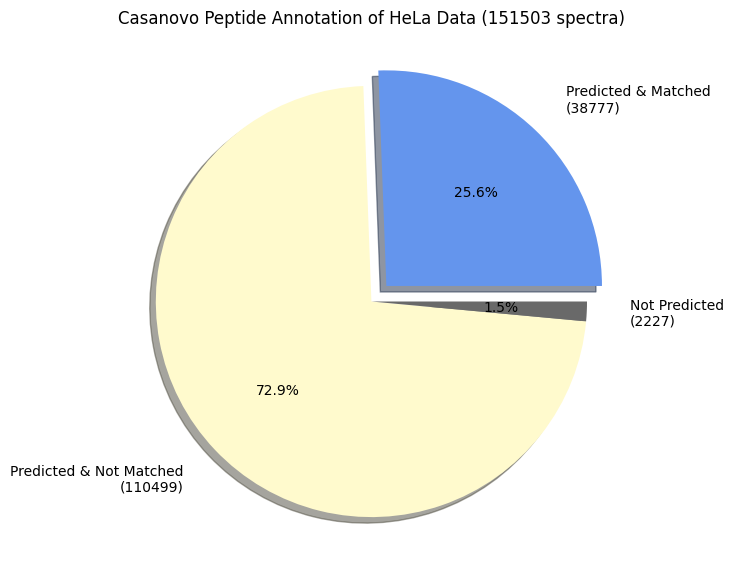

In [94]:
predicted_matched = matched_df.shape[0]
predicted_not_matched = df[(df['seq'] == '') & (df['casanovo_seq'] != '')].shape[0]
not_predicted = df[(df['seq'] == '') & (df['casanovo_seq'] == '')].shape[0]

# Plotting pie chart for peptides
labels = [f'Predicted & Matched\n({predicted_matched})',
          f'Predicted & Not Matched\n({predicted_not_matched})',
          f'Not Predicted\n({not_predicted})']
sizes = [predicted_matched, predicted_not_matched, not_predicted]
colors = ['cornflowerblue', 'lemonchiffon', 'dimgray']
explode = (0.1, 0, 0)  # explode the Predicted & Matched section
plt.figure(figsize=(10, 7))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=0, labeldistance=1.2)
plt.title('Casanovo Peptide Annotation of HeLa Data (151503 spectra)')
plt.show()

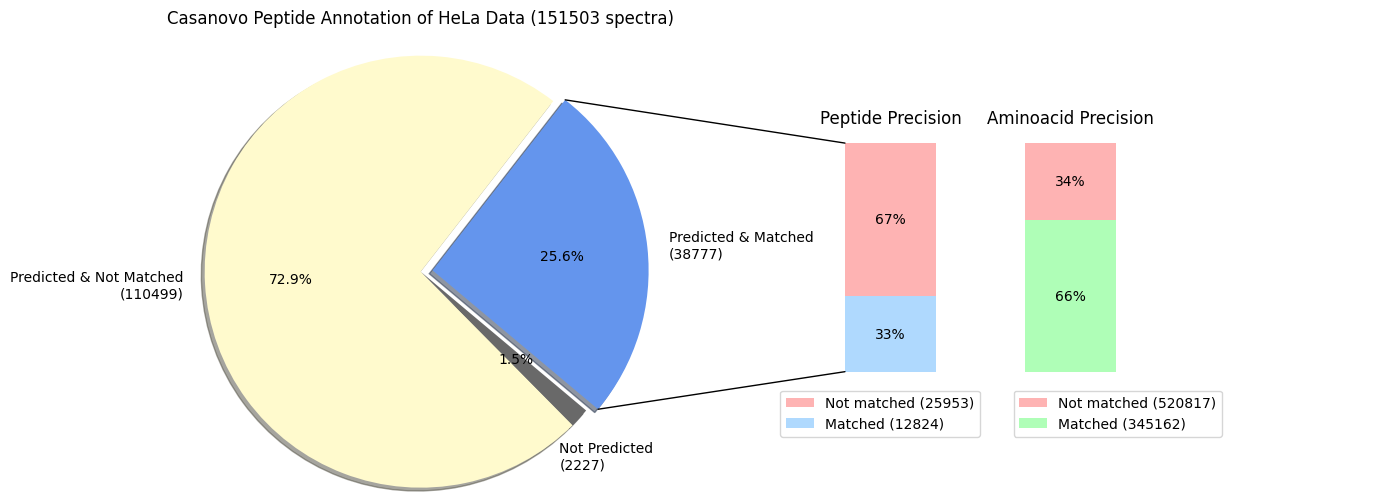

In [95]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import ConnectionPatch

def plot_matched_metrics(df, matched_df, matched_metrics):
    # Define your data
    predicted_matched = matched_df.shape[0]
    predicted_not_matched = df[(df['seq'] == '') & (df['casanovo_seq'] != '')].shape[0]
    not_predicted = df[(df['seq'] == '') & (df['casanovo_seq'] == '')].shape[0]
    
    #fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 4))
    #fig.subplots_adjust(wspace=0)
    
    fig = plt.figure(figsize=(10,5))
    left, bottom, width, height = 0.1, 0.1, 0.6, 0.6
    
    x_position = 0.1  # Fraction of figure width
    y_position = 0.3  # Fraction of figure height
    width = 0.8       # Fraction of figure width
    height = 0.6      # Fraction of figure height
    
    ax1 = fig.add_axes([0, 0, width, height])
    
    size_scale = 0.8
    
    ax2 = fig.add_axes([0.55, 0.1, size_scale*width, size_scale*height])
    
    ax3 = fig.add_axes([0.73, 0.1, size_scale*width, size_scale*height])
    
    # Additional bar chart 1
    # Define data for bar chart 1
    overall_ratios = [predicted_matched, predicted_not_matched, not_predicted]
    labels = [f'Predicted & Matched\n({predicted_matched})',
              f'Predicted & Not Matched\n({predicted_not_matched})',
              f'Not Predicted\n({not_predicted})']
    explode = (0.1, 0, 0)
    angle = -40
    colors = ['cornflowerblue', 'lemonchiffon', 'dimgray']
    wedges, texts, _ = ax1.pie(overall_ratios, autopct='%1.1f%%', startangle=angle, colors=colors, labels=labels, explode=explode, radius=1.8, shadow = True)
    ax1.set_title('Casanovo Peptide Annotation of HeLa Data (151503 spectra)', y=1.3)
    
    
    x,y = texts[2].get_position()
    texts[2].set_position((x - 0.3, y- 0.2))
    
    # Bar chart 1 for Peptide Precision
    pep_ratios = [matched_metrics['pep_precision in %']/100, 1-matched_metrics['pep_precision in %']/100]
    pep_labels = [f'Matched ({matched_metrics["n_total_correct_peptide"]})', f'Not matched ({matched_metrics["n_total_wrong_peptide"]})']
    bottom = 1
    width = .2
    pep_bar_colors = ['#60B5FE', '#FE6969']
    for j, (height, label, color) in enumerate(reversed([*zip(pep_ratios, pep_labels, pep_bar_colors)])):
        bottom -= height
        bc = ax2.bar(0, height, width, bottom=bottom, color=color, label=label, alpha=0.5)
        ax2.bar_label(bc, labels=[f"{height:.0%}"], label_type='center')
    
    ax2.set_title('Peptide Precision')
    ax2.legend(loc='best', bbox_to_anchor=(0.15, -0.3, 0.5, 0.5))
    ax2.axis('off')
    ax2.set_xlim(- 3.5 * width, 3.5 * width)
    
    # Bar chart 2 for AA Precision
    aa_ratios = [matched_metrics['aa_precision of total pred. AA in %']/100, 1-matched_metrics['aa_precision of total pred. AA in %']/100]
    aa_labels = [f"Matched ({matched_metrics['n_total_correct_aa']})", f"Not matched ({matched_metrics['n_total_aa']})"]
    bottom = 1
    width = .2
    aa_bar_colors = ['#60FE70', '#FE6969']
    for j, (height, label, color) in enumerate(reversed([*zip(aa_ratios, aa_labels, aa_bar_colors)])):
        bottom -= height
        bc = ax3.bar(0, height, width, bottom=bottom, color=color, label=label, alpha=0.5)
        ax3.bar_label(bc, labels=[f"{height:.0%}"], label_type='center')
    
    ax3.set_title('Aminoacid Precision')
    ax3.legend(loc='best', bbox_to_anchor=(0.4, -0.3, 0.5, 0.5))
    ax3.axis('off')
    ax3.set_xlim(- 3.5 * width, 3.5 * width)
    
    # Set up connections between the plots
    theta1, theta2 = wedges[0].theta1, wedges[0].theta2
    center, r = wedges[0].center, wedges[0].r
    bar_height = sum(pep_ratios)
    x = r * np.cos(np.pi / 180 * theta2) + center[0]
    y = r * np.sin(np.pi / 180 * theta2) + center[1]
    con = ConnectionPatch(xyA=(-width / 2, bar_height), coordsA=ax2.transData, xyB=(x, y), coordsB=ax1.transData)
    con.set_color([0, 0, 0])
    con.set_linewidth(1)
    ax2.add_artist(con)
    
    # Draw bottom connecting line
    x = r * np.cos(np.pi / 180 * theta1) + center[0]
    y = r * np.sin(np.pi / 180 * theta1) + center[1]
    con = ConnectionPatch(xyA=(-width / 2, 0), coordsA=ax2.transData, xyB=(x, y), coordsB=ax1.transData)
    con.set_color([0, 0, 0])
    ax2.add_artist(con)
    con.set_linewidth(1)
    
    plt.show()

plot_matched_metrics(df, matched_df, matched_metrics)

### Get metrics for modified dfs:

In [97]:
def calculate_modified_metrics(matched_df, aadict):
    mod_df = matched_df[(matched_df['db_modified'] == True) | (matched_df['cs_modified'] == True)]
    non_mod_df = matched_df[(matched_df['db_modified'] != True) & (matched_df['cs_modified'] != True)]
    mod_metrics = calculate_metrics(mod_df, aadict)
    non_mod_metrics = calculate_metrics(non_mod_df, aadict)

    return mod_metrics, non_mod_metrics

mod_metrics, non_mod_metrics = calculate_modified_metrics(matched_df, aadict)

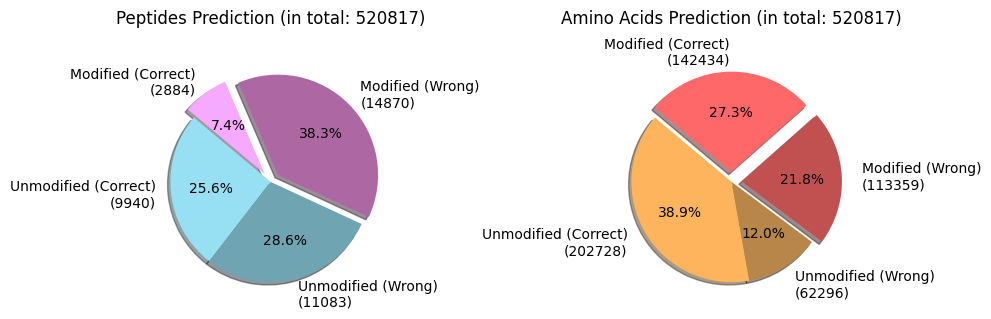

In [98]:
from typing import Dict, Any, Tuple, List

def plot_modified_metrics(matched_metrics: Dict[str, Any], mod_metrics: Dict[str, Any], non_mod_metrics: Dict[str, Any]) -> None:
    peptides_total: int = matched_metrics['n_total_aa']
    peptides_unmodified: int = peptides_total - mod_metrics['n_total_peptide']
    peptides_modified: int = mod_metrics['n_total_peptide']
    peptides_modified_correct: int = mod_metrics['n_total_correct_peptide']
    peptides_unmodified_correct: int = non_mod_metrics['n_total_correct_peptide']
    peptides_modified_wrong: int = mod_metrics['n_total_wrong_peptide']
    peptides_unmodified_wrong: int = non_mod_metrics['n_total_wrong_peptide']

    amino_acids_total: int = matched_metrics['n_total_aa']
    amino_acids_of_modified_peptides: int = mod_metrics['n_total_aa']
    amino_acids_of_unmodified_peptides: int = non_mod_metrics['n_total_aa']
    amino_acids_of_modified_correct: int = mod_metrics['n_total_correct_aa']
    amino_acids_of_unmodified_correct: int = non_mod_metrics['n_total_correct_aa']
    amino_acids_of_modified_wrong: int = mod_metrics['n_total_wrong_aa']
    amino_acids_of_unmodified_wrong: int = non_mod_metrics['n_total_wrong_aa']

    # Plotting pie chart for peptides
    labels_peptides: List[str] = [f'Unmodified (Correct)\n({peptides_unmodified_correct})',
                                  f'Unmodified (Wrong)\n({peptides_unmodified_wrong})',
                                  f'Modified (Wrong)\n({peptides_modified_wrong})',
                                  f'Modified (Correct)\n({peptides_modified_correct})']
    sizes_peptides: List[int] = [peptides_unmodified_correct, peptides_unmodified_wrong, peptides_modified_wrong, peptides_modified_correct]
    colors_peptides: List[str] = ['#97E0F4', '#6FA4B3', '#AD68A4', '#F6AAFF']
    explode_peptides: Tuple[float, ...] = (0, 0, 0.1, 0.1)  # explode the modified (correct) section
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.pie(sizes_peptides, explode=explode_peptides, labels=labels_peptides, colors=colors_peptides, autopct='%1.1f%%', shadow=True, startangle=140, labeldistance=1.15)
    plt.title(f'Peptides Prediction (in total: {peptides_total})', y=1.10)

    # Plotting pie chart for amino acids
    labels_aa: List[str] = [f'Unmodified (Correct)\n({amino_acids_of_unmodified_correct})',
                            f'Unmodified (Wrong)\n({amino_acids_of_unmodified_wrong})',
                            f'Modified (Wrong)\n({amino_acids_of_modified_wrong})',
                            f'Modified (Correct)\n({amino_acids_of_modified_correct})']
    sizes_aa: List[int] = [amino_acids_of_unmodified_correct, amino_acids_of_unmodified_wrong, amino_acids_of_modified_wrong, amino_acids_of_modified_correct]
    colors_aa: List[str] = ['#FEB45D', '#B9864A', '#C15151', '#FE6868']
    explode_aa: Tuple[float, ...] = (0, 0, 0.1, 0.1)  # explode the incorrect slice
    plt.subplot(1, 2, 2)
    plt.pie(sizes_aa, explode=explode_aa, labels=labels_aa, colors=colors_aa, autopct='%1.1f%%', shadow=True, startangle=140, labeldistance=1.2)
    plt.title(f'Amino Acids Prediction (in total: {amino_acids_total})', y=1.10)
    plt.subplots_adjust(wspace=0.5)
    plt.tight_layout()
    plt.show()

plot_modified_metrics(matched_metrics, mod_metrics, non_mod_metrics)

### Get aminoacid prediction score metrics:

#### Inspect Boolean of aa_match_batch() of casanovo:

In [99]:
matched_df_filtered = matched_df[matched_df['seq'].str.len() > matched_df['casanovo_seq'].str.len()]
matched_df_filtered.index.tolist()[0:20]

[4,
 19,
 20,
 25,
 28,
 31,
 42,
 45,
 47,
 48,
 53,
 90,
 104,
 115,
 119,
 122,
 125,
 127,
 130,
 134]

In [100]:
def tokenize(peptide):
    if isinstance(peptide, str):
        tokenized_peptide = re.split(r"(?<=.)(?=[A-Z])", peptide)

    return tokenized_peptide

In [127]:
aa_bool = aa_match_batch(
                database_pred, casanovo_pred, aadict, aa_score_list, cum_mass_threshold=np.inf
            )

In [128]:
from itertools import chain


boolean_aa_score_list = []

for array in aa_bool[0]:
    boolean_aa_score_list.append(array[0])
flat_boolean_aa_score_list = list(chain.from_iterable(boolean_aa_score_list))
len(flat_boolean_aa_score_list)

526557

In [129]:
def extract_correct_aa_scores(df, row_index, aa_scores_column):
    # Get the amino acid scores as a list of floats
    aa_score_list = df.iloc[row_index][aa_scores_column]
    
    # Tokenize the sequences
    seq = tokenize(df.iloc[row_index]['seq'])
    casanovo_seq = tokenize(df.iloc[row_index]['casanovo_seq'])
    row_index_matched_df = df.index.tolist()[row_index]
    # Initialize list to store correct amino acid scores
    
    forward_aa_score_list = []
    forward_matches = []
    # Forward comparison
    index = 0
    for step in range(0, min(len(seq), len(casanovo_seq))):
        boolean = boolean_aa_score_list[row_index_matched_df][index]
        cas_aa = casanovo_seq[index]
        db_aa = seq[index]
        if cas_aa == db_aa:
            forward_aa_score_list.append(aa_score_list[index])
            forward_matches.append(cas_aa)
        else:
            forward_aa_score_list.append(0.0)
            forward_matches.append('')
        index += 1

    reversed_aa_score_list = []
    reversed_matches = []
    # Reversed comparison
    index_db = len(seq) - 1
    index_cas = len(casanovo_seq) - 1
    
    for step in range(0, min(len(seq), len(casanovo_seq))):
        boolean = boolean_aa_score_list[row_index_matched_df][max(index_db, index_cas)]
        cas_aa = casanovo_seq[index_cas]
        db_aa = seq[index_db]
        if cas_aa == db_aa:
            reversed_aa_score_list.append(aa_score_list [index_cas])
            reversed_matches.append(cas_aa)
        else:
            reversed_aa_score_list.append(0.0)
            reversed_matches.append('')
        index_db -= 1
        index_cas -= 1
    
    return forward_aa_score_list, forward_matches, reversed_aa_score_list, reversed_matches

# Example usage:
correct_aa_scores = extract_correct_aa_scores(matched_df_filtered, 1, 'casanovo_aa_scores')
print(correct_aa_scores)

([0.0, 0.0, 0.60493, 0.0, 0.61474, 0.60406, 0.60601, 0.75741, 0.0, 0.0, 0.0, 0.0, 0.0], ['', '', 'P', '', 'N', 'S', 'T', 'Q', '', '', '', '', ''], [0.57806, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], ['K', '', '', '', '', '', '', '', '', '', '', '', ''])


In [130]:
aa_score_list = matched_df['casanovo_aa_scores'].tolist()

#### Plot aminoacid precision and recall at score thresholds between 0 and 1:

In [132]:
matched_df
casanovo_pred = matched_df['casanovo_seq']
database_pred = matched_df['seq']

In [133]:
def aa_metrics_at_score_threshold(df, aadict, cum_mass_threshold, score_threshold):
    casanovo_pred = df['casanovo_seq']
    database_pred = df['seq']
    aa_score_list = df['casanovo_aa_scores'].tolist()

    aa_bool = aa_match_batch(database_pred, casanovo_pred, aadict, aa_score_list, cum_mass_threshold=np.inf)
    n_total_aa = aa_bool[1]
    
    aa_scores_correct = []
    aa_scores_all = []

    for array in aa_bool[0]:
        aa_scores_all.append(array[2])
        indices = np.argwhere(array[0]).flatten()
        for index in indices:
            aa_scores_correct.append(array[2][index])

    aa_scores_all = list(chain.from_iterable(aa_scores_all))

    aa_precision, aa_recall = aa_precision_recall(aa_scores_correct, aa_scores_all, n_total_aa, score_threshold)

    return aa_precision, aa_recall

In [134]:
aa_precision, aa_recall = aa_metrics_at_score_threshold(matched_df, aadict, np.Inf, 0.95)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


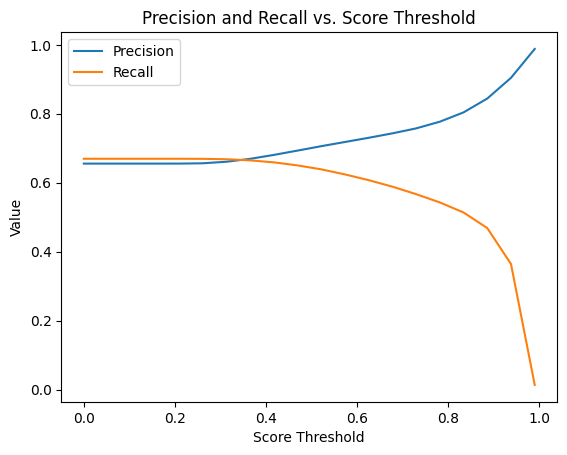

In [135]:
def plot_precision_recall(df, aadict, cum_mass_threshold, score_threshold_step = 10):
    precisions = []
    recalls = []

    score_thresholds = np.linspace(0, 0.99, score_threshold_step)
    
    for step, threshold in enumerate(score_thresholds):
        print(step)
        aa_precision, aa_recall = aa_metrics_at_score_threshold(df, aadict, np.Inf, threshold)
        precisions.append(aa_precision)
        recalls.append(aa_recall)
    
    plt.plot(score_thresholds, precisions, label='Precision')
    plt.plot(score_thresholds, recalls, label='Recall')
    plt.xlabel('Score Threshold')
    plt.ylabel('Value')
    plt.title('Precision and Recall vs. Score Threshold')
    plt.legend()
    plt.show()

    return score_thresholds, precisions, recalls

# Plot precision and recall
precision_recall_data = plot_precision_recall(matched_df, aadict, np.Inf, score_threshold_step = 20)

In [172]:
score_pr_df = pd.DataFrame({'score thresholds': precision_recall_data[0], 'precisions': precision_recall_data[1], 'recalls': precision_recall_data[2]})
score_pr_df

,score thresholds,precisions,recalls
0,0.000000,0.655507,0.669523
1,0.052105,0.655507,0.669523
2,0.104211,0.655507,0.669523
3,0.156316,0.655507,0.669523
4,0.208421,0.655530,0.669515
5,0.260526,0.656394,0.669325
6,0.312632,0.660846,0.668152
7,0.364737,0.669262,0.664883
8,0.416842,0.680633,0.659179
9,0.468947,0.693166,0.650374


#### Plot correctly and falsely matched aminoacid counts by their prediction score:

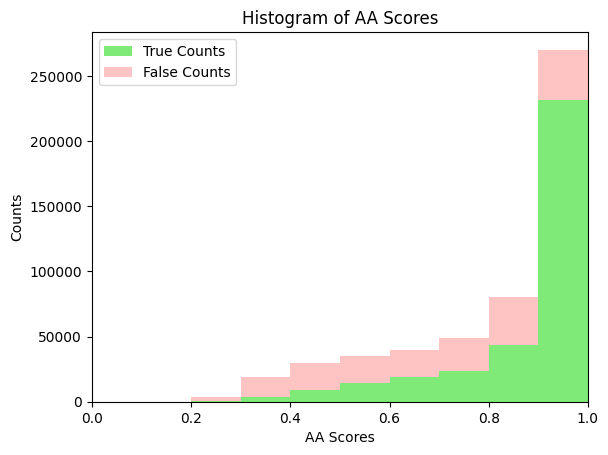

In [136]:
def plot_aa_scores_histogram(df, aadict, num_bins=9, cum_mass_threshold=np.inf):
    
    casanovo_pred = df['casanovo_seq']
    database_pred = df['seq']
    df['casanovo_aa_scores'].tolist()
    aa_score_list = df['casanovo_aa_scores'].tolist()

    aa_bool = aa_match_batch(database_pred, casanovo_pred, aadict, aa_score_list, cum_mass_threshold)
    aa_scores_all = []
    match_boolean_all = []
    for array in aa_bool[0]:
        match_boolean_all.append(array[0])
        aa_scores_all.append(array[2])

    aa_scores_all = list(chain.from_iterable(aa_scores_all))
    match_boolean_all = list(chain.from_iterable(match_boolean_all))

    # Convert lists to arrays
    aa_scores = np.array(aa_scores_all)
    match_boolean = np.array(match_boolean_all)

    # Define bins
    bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
    x_positions = [bin_value + 0.05 for bin_value in bins[:-1]]
    # Calculate histograms for True and False counts
    true_counts, _ = np.histogram(aa_scores[match_boolean], bins=bins)
    false_counts, _ = np.histogram(aa_scores[~match_boolean], bins=bins)

    # Plot histograms
    plt.bar(x_positions, true_counts, width=np.diff(bins), color='#2BDD1F', alpha=0.6, label='True Counts')
    plt.bar(x_positions, false_counts, width=np.diff(bins), color='#FE6969', alpha=0.4, bottom=true_counts, label='False Counts')
    plt.xlabel('AA Scores')
    plt.ylabel('Counts')
    plt.title('Histogram of AA Scores')
    plt.legend()
    # Set x-axis ticks to bin edges
    #plt.xticks(bins[:-1], bins[:-1]) 
    plt.xlim(0,1)
    plt.show()
    #plt.savefig("histogram_of_aa_scores.png")
    return true_counts, false_counts

true_counts, false_counts = plot_aa_scores_histogram(matched_df, aadict, num_bins=9, cum_mass_threshold=np.inf)

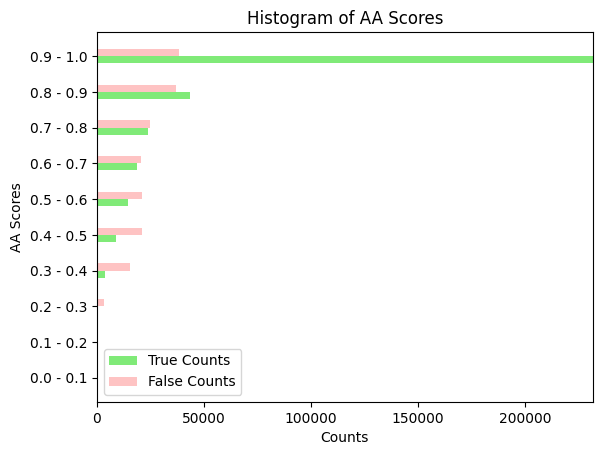

In [137]:
import matplotlib.pyplot as plt
import numpy as np
from itertools import chain

def plot_aa_scores_horizontal(df, aadict, cum_mass_threshold=np.inf):
    # Extract relevant data from the DataFrame
    casanovo_pred = df['casanovo_seq']
    database_pred = df['seq']
    aa_score_list = df['casanovo_aa_scores'].tolist()

    # Perform AA matching batch
    aa_bool = aa_match_batch(database_pred, casanovo_pred, aadict, aa_score_list, cum_mass_threshold)

    # Extract match boolean and AA scores
    match_boolean_all = [array[0] for array in aa_bool[0]]
    aa_scores_all = [array[2] for array in aa_bool[0]]

    # Flatten lists
    aa_scores_all = list(chain.from_iterable(aa_scores_all))
    match_boolean_all = list(chain.from_iterable(match_boolean_all))

    # Convert lists to arrays
    aa_scores = np.array(aa_scores_all)
    match_boolean = np.array(match_boolean_all)

    # Define bins
    bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

    # Calculate histograms for True and False counts
    true_counts, _ = np.histogram(aa_scores[match_boolean], bins=bins)
    false_counts, _ = np.histogram(aa_scores[~match_boolean], bins=bins)

    # Calculate bar heights
    bar_height = 0.2

    # Calculate bar positions
    y_positions = np.arange(len(bins[:-1]))

    # Plot histograms using Matplotlib
    plt.barh(y_positions - bar_height/2, true_counts, height=bar_height, color='#2BDD1F', alpha=0.6, label='True Counts')
    plt.barh(y_positions + bar_height/2, false_counts, height=bar_height, color='#FE6969', alpha=0.4, label='False Counts')

    # Add group labels
    tick_labels = [f'{bins[i]:.1f} - {bins[i+1]:.1f}' for i in range(len(bins)-1)]
    plt.yticks(y_positions, tick_labels)
    
    plt.xlabel('Counts')
    plt.ylabel('AA Scores')
    plt.title('Histogram of AA Scores')
    plt.xlim(0, max(max(true_counts), max(false_counts))+10)
    plt.legend()
    plt.show()

    return true_counts, false_counts

true_counts, false_counts = plot_aa_scores_horizontal(matched_df, aadict, cum_mass_threshold=np.inf)

In [176]:
bin_labels = ['0 - 0.1', '0.1 - 0.2', '0.2 - 0.3', '0.3 - 0.4', '0.4 - 0.5', '0.5 - 0.6', '0.6 - 0.7', '0.7 - 0.8', '0.8 - 0.9', '0.9 - 1']

# Create a DataFrame
aa_scores_hist_df = pd.DataFrame({'bin range': bin_labels, 'true_counts': true_counts, 'false_counts': false_counts})

aa_scores_hist_df

,bin range,true_counts,false_counts
0,0 - 0.1,0,0
1,0.1 - 0.2,0,4
2,0.2 - 0.3,502,3282
3,0.3 - 0.4,3688,15388
4,0.4 - 0.5,9011,21058
5,0.5 - 0.6,14378,20882
6,0.6 - 0.7,18782,20739
7,0.7 - 0.8,23680,24895
8,0.8 - 0.9,43378,36858
9,0.9 - 1,231743,38289


### Analyze Dark Data and get peptides with high mean score (0.9 - 1.0):

In [113]:
casanovo_unmatched_df = df[(df['seq'] == '') & (df['casanovo_seq'] != '')]

In [114]:
casanovo_unmatched_df

,title,pepmass,rtinseconds,charge,ion_mobility,scans,casanovo_seq,casanovo_aa_scores,seq,m/z array,intensity array,db_modified,cs_modified
0,1,"(663.2879991882091, None)",1.527828,[2+],0.8166844415024028,F8:1777.0,TLHTLLLDNRK,"[0.62897, 0.46597, 0.40492, 0.38024, 0.31451, ...",,"[273.03466354161986, 360.92334212510104, 400.3...","[56.0, 138.0, 63.0, 115.0, 115.0, 76.0, 112.0,...",False,False
1,2,"(1221.9899373704318, None)",2.399628,[1+],1.2557798217225913,F16:3885.0,NDLLLEKEEK,"[0.48481, 0.2251, 0.24477, 0.27449, 0.28019, 0...",,"[553.9489515333205, 558.5288494547539, 877.954...","[85.0, 11.0, 61.0, 49.0, 31.0, 62.0, 45.0, 45....",False,False
2,3,"(1223.9922918996538, None)",2.973578,[1+],1.3628076304583132,F21:3454.0,KPREC+57.021ESC+57.021R,"[0.44714, 0.24382, 0.22875, 0.23995, 0.36384, ...",,"[230.92269514520777, 245.9377834925359, 319.93...","[98.0, 77.0, 81.0, 71.0, 125.0, 96.0, 141.0, 6...",False,True
3,4,"(922.0052771097749, None)",2.973578,[1+],1.113046705532348,F21:2708.0,PMGLLRLK,"[0.70436, 0.43039, 0.47188, 0.53315, 0.39718, ...",,"[614.6492959691126, 616.6141580080161, 624.611...","[75.0, 67.0, 24.0, 45.0, 39.0, 53.0, 85.0, 76....",False,False
22,23,"(466.8164532109858, None)",2.973578,[1+],0.8072465531378396,F21:5141.0,LNNNN,"[0.2167, 0.21841, 0.22674, 0.20244, 0.21438]",,[561.2985454672379],[72.0],False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
151498,151499,"(623.0248420939173, None)",3584.723493,[1+],0.9613576822314688,F33077:2258.0,HDC+57.021DK,"[0.32813, 0.38435, 0.6269, 0.32973, 0.33301]",,"[200.99180651257458, 290.92891283118473, 393.9...","[10.0, 65.0, 62.0, 71.0, 71.0, 102.0, 70.0, 49...",False,True
151499,151500,"(622.0267592077544, None)",3585.272101,[1+],0.9782158702844477,F33082:25826.0,EC+57.021FER,"[0.35393, 0.30745, 0.232, 0.51399, 0.25483]",,"[188.0090480275357, 209.95023734750205, 225.93...","[59.0, 110.0, 157.0, 104.0, 88.0, 10.0, 186.0,...",False,True
151500,151501,"(1223.9880700318918, None)",3586.245334,[1+],1.3611104452168818,F33090:1846.0,QYGPKPPTVLK,"[0.72467, 0.4365, 0.43237, 0.49246, 0.78193, 0...",,"[227.93117309197157, 250.83549331644747, 250.8...","[189.0, 31.0, 28.0, 133.0, 64.0, 136.0, 106.0,...",False,False
151501,151502,"(1221.9879333107788, None)",3589.934304,[1+],1.3690286963761604,F33121:50923.0,LC+57.021EDRLDNGK,"[0.8115, 0.66726, 0.7572, 0.48835, 0.42572, 0....",,"[248.9179004506173, 250.9229450401413, 277.928...","[32.0, 67.0, 105.0, 81.0, 10.0, 171.0, 10.0, 3...",False,True


In [152]:
casanovo_unmatched_df.loc[:,'mean_aa_score'] = [np.mean(scores) for scores in casanovo_unmatched_df['casanovo_aa_scores'].tolist()]

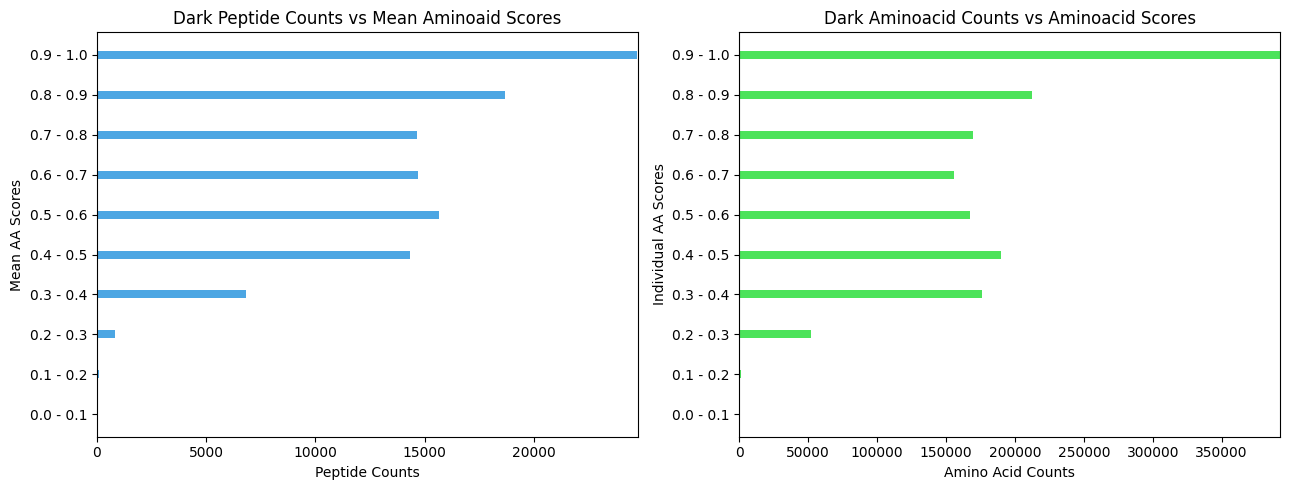

In [116]:
def plot_dark_scores_horizontal(df, aadict, cum_mass_threshold=np.inf):
    # Extract relevant data from the DataFrame
    casanovo_pred = df['casanovo_seq']
    aa_score_list = df['casanovo_aa_scores'].tolist()

    aa_scores_all = list(chain.from_iterable(aa_score_list))
    # Calculate mean scores of peptides
    mean_scores_of_peptides = [np.mean(scores) for scores in aa_score_list]
    
    # Define bins
    bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

    # Calculate histograms for mean scores of peptides
    peptide_counts, _ = np.histogram(mean_scores_of_peptides, bins=bins)
    aa_counts, _ = np.histogram(aa_scores_all, bins=bins)

    # Calculate bar heights
    bar_height = 0.2

    # Calculate bar positions
    y_positions = np.arange(len(bins[:-1]))

    # Create subplots
    fig, axs = plt.subplots(1, 2, figsize=(13, 5))

    # Plot histograms using Matplotlib
    axs[0].barh(y_positions, peptide_counts, height=bar_height, color='#1F90DD', alpha=0.8, label='Peptide Counts')
    axs[1].barh(y_positions, aa_counts, height=bar_height, color='#1FDD31', alpha=0.8, label='Amino Acid Counts')

    # Add group labels
    tick_labels = [f'{bins[i]:.1f} - {bins[i+1]:.1f}' for i in range(len(bins)-1)]
    axs[0].set_yticks(y_positions)
    axs[0].set_yticklabels(tick_labels)
    axs[1].set_yticks(y_positions)
    axs[1].set_yticklabels(tick_labels)
    
    axs[0].set_xlabel('Peptide Counts')
    axs[1].set_xlabel('Amino Acid Counts')
    axs[0].set_ylabel('Mean AA Scores')
    axs[1].set_ylabel('Individual AA Scores')
    axs[0].set_title('Dark Peptide Counts vs Mean Aminoaid Scores')
    axs[1].set_title('Dark Aminoacid Counts vs Aminoacid Scores')
    axs[0].set_xlim(0, max(peptide_counts) + 10)
    axs[1].set_xlim(0, max(aa_counts) + 10)

    plt.tight_layout()
    plt.show()

    return mean_scores_of_peptides, peptide_counts, aa_counts

mean_scores_of_peptides, peptide_counts, aa_counts = plot_dark_scores_horizontal(casanovo_unmatched_df, aadict, cum_mass_threshold=np.inf)


In [117]:
peptide_counts

array([    0,    74,   848,  6812, 14336, 15664, 14682, 14674, 18669,
       24740])

In [118]:
aa_counts

array([     4,    871,  52235, 175749, 190098, 167571, 155712, 169365,
       212372, 392379])

In [119]:
high_mean_aa_score_peptides = casanovo_unmatched_df[casanovo_unmatched_df['mean_aa_score'] >= 0.9]

In [120]:
high_mean_aa_score_peptides

,title,pepmass,rtinseconds,charge,ion_mobility,scans,casanovo_seq,casanovo_aa_scores,seq,m/z array,intensity array,db_modified,cs_modified,mean_aa_score
406,407,"(842.9035361246644, None)",419.180763,[2+],1.0147815679606023,F3487:42381.0,EQQQQQQQQQQQK,"[0.97043, 0.97145, 0.97275, 0.97308, 0.97314, ...",,"[167.09287736323137, 240.099827596804, 242.110...","[85.0, 472.0, 136.0, 80.0, 74.0, 103.0, 114.0,...",False,False,0.954533
450,451,"(516.7634567388639, None)",420.350962,[2+],0.8106028537237576,F3498:43764.0,APGTPHSHTK,"[0.94065, 0.92083, 0.97895, 0.98049, 0.98108, ...",,"[196.14593405359054, 208.12562969795786, 209.1...","[33.0, 106.0, 99.0, 126.0, 119.0, 101.0, 114.0...",False,False,0.967511
452,453,"(344.84357427933645, None)",420.350962,[3+],0.6609748466561632,F3498:22807.0,APGTPHSHTK,"[0.93299, 0.96249, 0.95395, 0.96814, 0.96855, ...",,"[225.0964051661733, 231.13369547797018, 235.12...","[90.0, 34.0, 150.0, 145.0, 62.0, 93.0, 201.0, ...",False,False,0.941116
456,457,"(516.7632365678688, None)",420.350962,[2+],0.8445387827269866,F3498:17965.0,APGTPHSHTK,"[0.96732, 0.96846, 0.97218, 0.97168, 0.97201, ...",,"[210.13542282493052, 235.1223054025792, 238.11...","[179.0, 99.0, 63.0, 79.0, 15.0, 257.0, 66.0, 1...",False,False,0.948805
468,469,"(340.2016005669674, None)",420.350962,[2+],0.6917447890982745,F3498:12259.0,GPGPPPR,"[0.94588, 0.96228, 0.96045, 0.96072, 0.96042, ...",,"[237.1366934967142, 237.14398122140636, 249.13...","[94.0, 59.0, 114.0, 100.0, 173.0, 59.0, 75.0, ...",False,False,0.928171
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151008,151009,"(704.8338525680721, None)",3343.022244,[2+],0.9636146248747218,F30963:51657.0,PMELFSELAEDK,"[0.98327, 0.98011, 0.98263, 0.98454, 0.98444, ...",,"[201.01417153017272, 201.10588111090868, 201.1...","[72.0, 562.0, 65.0, 147.0, 87.0, 142.0, 95.0, ...",False,False,0.975562
151083,151084,"(829.9228812513311, None)",3383.174162,[2+],1.0649016345019877,F31326:1911.0,DLADELALVDVLEDK,"[0.95472, 0.95315, 0.95598, 0.95783, 0.95878, ...",,"[201.12154093453705, 202.46383268131925, 228.0...","[52.0, 24.0, 73.0, 133.0, 87.0, 153.0, 99.0, 9...",False,False,0.924545
151093,151094,"(711.8400118275151, None)",3386.643982,[2+],0.9730302243010961,F31358:11884.0,PMELFTELADEK,"[0.89934, 0.76858, 0.91037, 0.94778, 0.94086, ...",,"[201.10364404301725, 201.10811819124248, 243.1...","[122.0, 298.0, 86.0, 124.0, 96.0, 61.0, 52.0, ...",False,False,0.901087
151113,151114,"(645.8417350087976, None)",3388.984397,[2+],0.9627503300680705,F31380:8936.0,C+57.021LESLLAVFQK,"[0.98118, 0.97888, 0.98084, 0.96764, 0.98145, ...",,"[228.68915279954516, 229.1020412787415, 229.10...","[104.0, 269.0, 75.0, 80.0, 32.0, 106.0, 31.0, ...",False,True,0.971375


In [158]:
duplicate_sequences = high_mean_aa_score_peptides[high_mean_aa_score_peptides['casanovo_seq'].duplicated(keep=False)]
duplicate_counts = duplicate_sequences['casanovo_seq'].value_counts()
duplicate_counts[0:20]

casanovo_seq
C+57.021DSSPDSAEDVRK               35
YPLEHGLLTNWDDMEK                   32
+42.011DDDLAALVVDNGSGMC+57.021K    27
EDQTEYLEER                         22
QEYDESGPSLVHR                      22
EDTEEHHLR                          21
VAPEEHPVLLTEAPLNPK                 20
QVHPDTGLSSK                        19
HLQLALR                            18
LENHEGVR                           17
YRPGTVALR                          16
LLSNASC+57.021TTNC+57.021LAPLAK    15
DSYVGDEAQSK                        15
-17.027QEYDESGPSLVHR               15
PEEHPVLLTEAPLNPK                   14
LSGLLYEETR                         13
+42.011SETAPAAPAAPAPAEK            13
DATNVGDEGGFAPNLLENK                13
PDTGLSSK                           13
TLTLEVEPSDTLENVK                   12
Name: count, dtype: int64

In [159]:
modified_sequences = high_mean_aa_score_peptides[high_mean_aa_score_peptides['cs_modified'] == True]
modified_counts = modified_sequences['casanovo_seq'].value_counts()
modified_counts[0:20]

casanovo_seq
C+57.021DSSPDSAEDVRK                   35
+42.011DDDLAALVVDNGSGMC+57.021K        27
LLSNASC+57.021TTNC+57.021LAPLAK        15
-17.027QEYDESGPSLVHR                   15
+42.011SETAPAAPAAPAPAEK                13
C+57.021DVDLR                          12
+42.011SETAPAAPAAAPPAEK                11
+43.006APLDPVAGYK                      11
C+57.021EMEQQNQEYK                     11
+42.011ADKPDMGELASFDK                  11
C+57.021NLLAEK                         10
LQC+57.021YNC+57.021PNPTADC+57.021K     9
EPAC+57.021DDPDTEQAALAAVDYLNK           9
-17.027QTVQEAWAEDVDLR                   9
+42.011SDAAVDTSSELTTK                   9
SYC+57.021AELAHNVSSK                    9
+43.006LPLEHGLLTNWDDMEK                 9
VDC+57.021TAHSDVC+57.021SAQGVR          8
+43.006C+57.021DSSPDSAEDVRK             8
LKPDPNTLC+57.021DEFK                    8
Name: count, dtype: int64

In [160]:
non_modified_sequences = high_mean_aa_score_peptides[high_mean_aa_score_peptides['cs_modified'] == False]
non_modified_counts = non_modified_sequences['casanovo_seq'].value_counts()
non_modified_counts[0:20]

casanovo_seq
YPLEHGLLTNWDDMEK       32
QEYDESGPSLVHR          22
EDQTEYLEER             22
EDTEEHHLR              21
VAPEEHPVLLTEAPLNPK     20
QVHPDTGLSSK            19
HLQLALR                18
LENHEGVR               17
YRPGTVALR              16
DSYVGDEAQSK            15
PEEHPVLLTEAPLNPK       14
DATNVGDEGGFAPNLLENK    13
LSGLLYEETR             13
PDTGLSSK               13
SYELPDGQVLTLGNER       12
VDNDENEHQLSLR          12
TLTLEVEPSDTLENVK       12
RVTLMPK                11
FFESFGDLSSADALLGNPK    11
NDEELNK                11
Name: count, dtype: int64

In [166]:
1-len(high_mean_aa_score_peptides['casanovo_seq'].unique())/len(high_mean_aa_score_peptides['casanovo_seq'])

0.25719482619240097

In [123]:
df[(df['casanovo_seq'] != '') & (df['seq'] == '')]

,title,pepmass,rtinseconds,charge,ion_mobility,scans,casanovo_seq,casanovo_aa_scores,seq,m/z array,intensity array,db_modified,cs_modified
0,1,"(663.2879991882091, None)",1.527828,[2+],0.8166844415024028,F8:1777.0,TLHTLLLDNRK,"[0.62897, 0.46597, 0.40492, 0.38024, 0.31451, ...",,"[273.03466354161986, 360.92334212510104, 400.3...","[56.0, 138.0, 63.0, 115.0, 115.0, 76.0, 112.0,...",False,False
1,2,"(1221.9899373704318, None)",2.399628,[1+],1.2557798217225913,F16:3885.0,NDLLLEKEEK,"[0.48481, 0.2251, 0.24477, 0.27449, 0.28019, 0...",,"[553.9489515333205, 558.5288494547539, 877.954...","[85.0, 11.0, 61.0, 49.0, 31.0, 62.0, 45.0, 45....",False,False
2,3,"(1223.9922918996538, None)",2.973578,[1+],1.3628076304583132,F21:3454.0,KPREC+57.021ESC+57.021R,"[0.44714, 0.24382, 0.22875, 0.23995, 0.36384, ...",,"[230.92269514520777, 245.9377834925359, 319.93...","[98.0, 77.0, 81.0, 71.0, 125.0, 96.0, 141.0, 6...",False,True
3,4,"(922.0052771097749, None)",2.973578,[1+],1.113046705532348,F21:2708.0,PMGLLRLK,"[0.70436, 0.43039, 0.47188, 0.53315, 0.39718, ...",,"[614.6492959691126, 616.6141580080161, 624.611...","[75.0, 67.0, 24.0, 45.0, 39.0, 53.0, 85.0, 76....",False,False
22,23,"(466.8164532109858, None)",2.973578,[1+],0.8072465531378396,F21:5141.0,LNNNN,"[0.2167, 0.21841, 0.22674, 0.20244, 0.21438]",,[561.2985454672379],[72.0],False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
151498,151499,"(623.0248420939173, None)",3584.723493,[1+],0.9613576822314688,F33077:2258.0,HDC+57.021DK,"[0.32813, 0.38435, 0.6269, 0.32973, 0.33301]",,"[200.99180651257458, 290.92891283118473, 393.9...","[10.0, 65.0, 62.0, 71.0, 71.0, 102.0, 70.0, 49...",False,True
151499,151500,"(622.0267592077544, None)",3585.272101,[1+],0.9782158702844477,F33082:25826.0,EC+57.021FER,"[0.35393, 0.30745, 0.232, 0.51399, 0.25483]",,"[188.0090480275357, 209.95023734750205, 225.93...","[59.0, 110.0, 157.0, 104.0, 88.0, 10.0, 186.0,...",False,True
151500,151501,"(1223.9880700318918, None)",3586.245334,[1+],1.3611104452168818,F33090:1846.0,QYGPKPPTVLK,"[0.72467, 0.4365, 0.43237, 0.49246, 0.78193, 0...",,"[227.93117309197157, 250.83549331644747, 250.8...","[189.0, 31.0, 28.0, 133.0, 64.0, 136.0, 106.0,...",False,False
151501,151502,"(1221.9879333107788, None)",3589.934304,[1+],1.3690286963761604,F33121:50923.0,LC+57.021EDRLDNGK,"[0.8115, 0.66726, 0.7572, 0.48835, 0.42572, 0....",,"[248.9179004506173, 250.9229450401413, 277.928...","[32.0, 67.0, 105.0, 81.0, 10.0, 171.0, 10.0, 3...",False,True


In [180]:
casanovo_unmatched_df.shape[0]

110499

In [182]:
high_mean_aa_score_peptides.shape[0]

24740

In [124]:
110499 - 24740

85759

In [125]:
24740/38777

0.6380070660443046

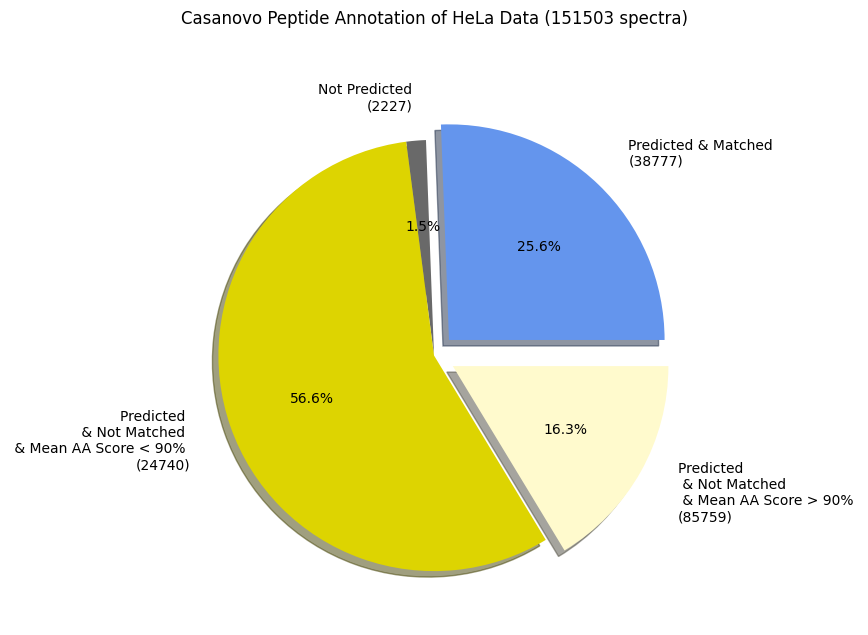

In [190]:
predicted_matched = matched_df.shape[0]
predicted_not_matched = df[(df['seq'] == '') & (df['casanovo_seq'] != '')].shape[0]
not_predicted = df[(df['seq'] == '') & (df['casanovo_seq'] == '')].shape[0]

total_dark_annotation = casanovo_unmatched_df.shape[0]
high_score_dark_annotation = high_mean_aa_score_peptides.shape[0]
low_score_dark_annotation = total_dark_annotation - high_mean_aa_score_peptides.shape[0]



# Plotting pie chart for peptides
labels = [f'Predicted & Matched\n({predicted_matched})',
          f'Not Predicted\n({not_predicted})',
          f'Predicted \n & Not Matched \n & Mean AA Score < 90% \n({high_score_dark_annotation})',
            
            f'Predicted \n & Not Matched \n & Mean AA Score > 90% \n({low_score_dark_annotation})',
          ]
sizes = [predicted_matched, not_predicted, low_score_dark_annotation,  high_score_dark_annotation]
colors = ['cornflowerblue', 'dimgray',  '#DDD401', 'lemonchiffon']
explode = (0.1, 0, 0, 0.1)  # explode the Predicted & Matched section
plt.figure(figsize=(10, 7))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=0, labeldistance=1.2)
plt.title('Casanovo Peptide Annotation of HeLa Data (151503 spectra)', y = 1.1)
plt.show()

In [214]:
duplicate_count= duplicate_sequences.shape[0]
duplicate_count

9746

In [220]:
duplicate_sequences = high_mean_aa_score_peptides[high_mean_aa_score_peptides['casanovo_seq'].duplicated(keep=False)]
duplicate_counts = duplicate_sequences['casanovo_seq'].value_counts()
duplicate_ratio = 1 - (len(high_mean_aa_score_peptides['casanovo_seq'].unique()) / len(high_mean_aa_score_peptides['casanovo_seq']))
duplicate_ratio

0.25719482619240097

In [218]:
9746*100/110499

8.819989321170327

In [304]:
high_mean_aa_score_peptides

,title,pepmass,rtinseconds,charge,ion_mobility,scans,casanovo_seq,casanovo_aa_scores,seq,m/z array,intensity array,db_modified,cs_modified,mean_aa_score
406,407,"(842.9035361246644, None)",419.180763,[2+],1.0147815679606023,F3487:42381.0,EQQQQQQQQQQQK,"[0.97043, 0.97145, 0.97275, 0.97308, 0.97314, ...",,"[167.09287736323137, 240.099827596804, 242.110...","[85.0, 472.0, 136.0, 80.0, 74.0, 103.0, 114.0,...",False,False,0.954533
450,451,"(516.7634567388639, None)",420.350962,[2+],0.8106028537237576,F3498:43764.0,APGTPHSHTK,"[0.94065, 0.92083, 0.97895, 0.98049, 0.98108, ...",,"[196.14593405359054, 208.12562969795786, 209.1...","[33.0, 106.0, 99.0, 126.0, 119.0, 101.0, 114.0...",False,False,0.967511
452,453,"(344.84357427933645, None)",420.350962,[3+],0.6609748466561632,F3498:22807.0,APGTPHSHTK,"[0.93299, 0.96249, 0.95395, 0.96814, 0.96855, ...",,"[225.0964051661733, 231.13369547797018, 235.12...","[90.0, 34.0, 150.0, 145.0, 62.0, 93.0, 201.0, ...",False,False,0.941116
456,457,"(516.7632365678688, None)",420.350962,[2+],0.8445387827269866,F3498:17965.0,APGTPHSHTK,"[0.96732, 0.96846, 0.97218, 0.97168, 0.97201, ...",,"[210.13542282493052, 235.1223054025792, 238.11...","[179.0, 99.0, 63.0, 79.0, 15.0, 257.0, 66.0, 1...",False,False,0.948805
468,469,"(340.2016005669674, None)",420.350962,[2+],0.6917447890982745,F3498:12259.0,GPGPPPR,"[0.94588, 0.96228, 0.96045, 0.96072, 0.96042, ...",,"[237.1366934967142, 237.14398122140636, 249.13...","[94.0, 59.0, 114.0, 100.0, 173.0, 59.0, 75.0, ...",False,False,0.928171
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151008,151009,"(704.8338525680721, None)",3343.022244,[2+],0.9636146248747218,F30963:51657.0,PMELFSELAEDK,"[0.98327, 0.98011, 0.98263, 0.98454, 0.98444, ...",,"[201.01417153017272, 201.10588111090868, 201.1...","[72.0, 562.0, 65.0, 147.0, 87.0, 142.0, 95.0, ...",False,False,0.975562
151083,151084,"(829.9228812513311, None)",3383.174162,[2+],1.0649016345019877,F31326:1911.0,DLADELALVDVLEDK,"[0.95472, 0.95315, 0.95598, 0.95783, 0.95878, ...",,"[201.12154093453705, 202.46383268131925, 228.0...","[52.0, 24.0, 73.0, 133.0, 87.0, 153.0, 99.0, 9...",False,False,0.924545
151093,151094,"(711.8400118275151, None)",3386.643982,[2+],0.9730302243010961,F31358:11884.0,PMELFTELADEK,"[0.89934, 0.76858, 0.91037, 0.94778, 0.94086, ...",,"[201.10364404301725, 201.10811819124248, 243.1...","[122.0, 298.0, 86.0, 124.0, 96.0, 61.0, 52.0, ...",False,False,0.901087
151113,151114,"(645.8417350087976, None)",3388.984397,[2+],0.9627503300680705,F31380:8936.0,C+57.021LESLLAVFQK,"[0.98118, 0.97888, 0.98084, 0.96764, 0.98145, ...",,"[228.68915279954516, 229.1020412787415, 229.10...","[104.0, 269.0, 75.0, 80.0, 32.0, 106.0, 31.0, ...",False,True,0.971375


                             metrics_of_unmatched_data
total_predicted_not_matched                  110499.00
high_score_annotations                        24740.00
duplicates                                     6363.00
duplicate_ratio                                   0.26
unique_ratio                                      0.74
modified                                       7800.00
modified_ratio                                    0.32
non_modified_ratio                                0.68


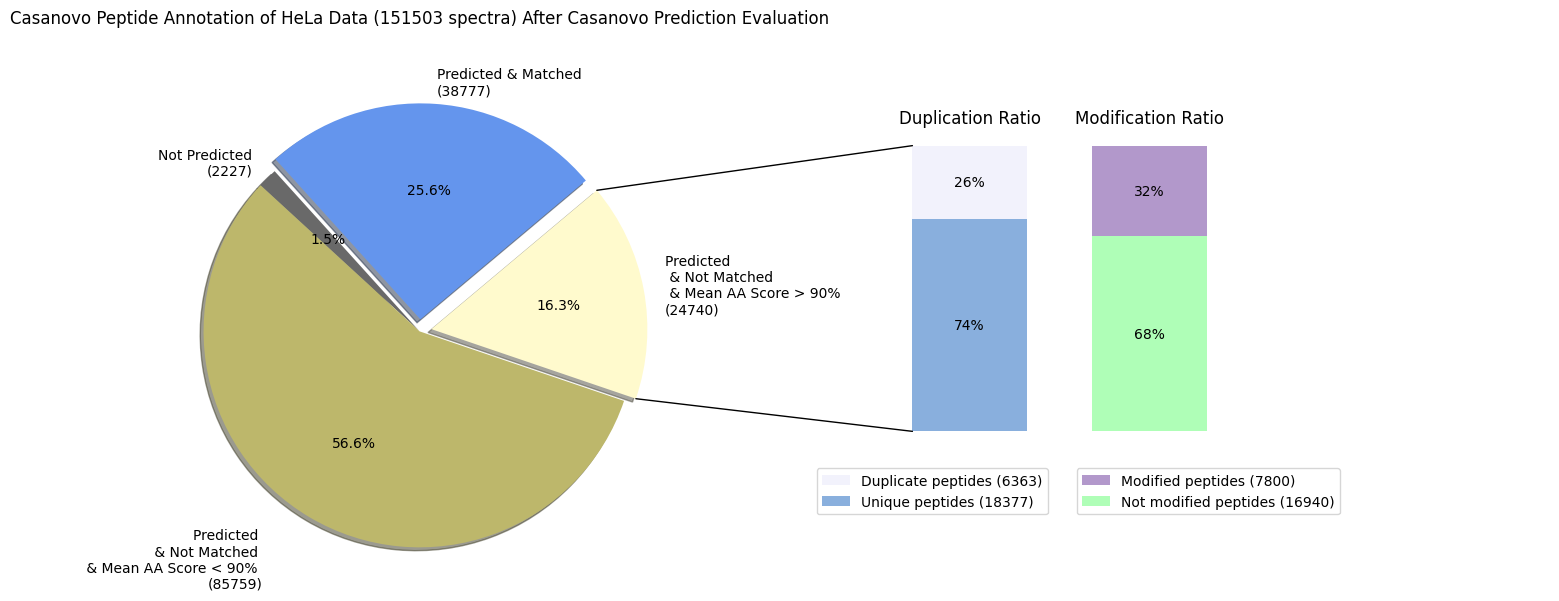

In [326]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import ConnectionPatch

def plot_dark_metrics(df, matched_df, casanovo_unmatched_df, high_mean_aa_score_peptides, modified_bool):
    # Define your data
    predicted_matched = matched_df.shape[0]
    predicted_not_matched = df[(df['seq'] == '') & (df['casanovo_seq'] != '')].shape[0]
    not_predicted = df[(df['seq'] == '') & (df['casanovo_seq'] == '')].shape[0]
    total_dark_annotation = casanovo_unmatched_df.shape[0]
    high_score_dark_annotation = high_mean_aa_score_peptides.shape[0]
    low_score_dark_annotation = total_dark_annotation - high_mean_aa_score_peptides.shape[0]

    duplicate_sequences = high_mean_aa_score_peptides[high_mean_aa_score_peptides['casanovo_seq'].duplicated(keep=False)]
    duplicate_data = duplicate_sequences['casanovo_seq'].value_counts()
    unique_counts = len(high_mean_aa_score_peptides['casanovo_seq'].unique())
    duplicate_counts = high_score_dark_annotation - unique_counts
    duplicate_ratio = 1 - (unique_counts / high_score_dark_annotation)

    dark_metrics = {'total_predicted_not_matched':int(total_dark_annotation), 
                    'high_score_annotations':int(high_score_dark_annotation), 'duplicates': int(duplicate_counts),
                            'duplicate_ratio': round(duplicate_ratio,2), 'unique_ratio': round(1-duplicate_ratio,2)}
    
    dark_df = pd.DataFrame.from_dict({'metrics_of_unmatched_data':dark_metrics}).reindex(index=['total_predicted_not_matched',
                                                                                             'high_score_annotations',
                                                                                                'duplicates',
                                                                                             'duplicate_ratio', 
                                                                                             'unique_ratio'])
    
    #fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 4))
    #fig.subplots_adjust(wspace=0)
    
    fig = plt.figure(figsize=(10,5))
    left, bottom, width, height = 0.1, 0.1, 0.6, 0.6
    
    x_position = 0.1  # Fraction of figure width
    y_position = 0.3  # Fraction of figure height
    width = 0.8       # Fraction of figure width
    height = 0.6      # Fraction of figure height
    
    ax1 = fig.add_axes([0, 0, width, height])
    


    # Define data for pie chart
    overall_ratios = [predicted_matched, not_predicted, low_score_dark_annotation,  high_score_dark_annotation]
    labels = [f'Predicted & Matched\n({predicted_matched})',
              f'Not Predicted\n({not_predicted})', 
                f'Predicted \n & Not Matched \n & Mean AA Score < 90% \n({low_score_dark_annotation})',
                f'Predicted \n & Not Matched \n & Mean AA Score > 90% \n({high_score_dark_annotation})',
          ]
    explode = (0.1, 0, 0, 0.1) 
    angle = 40
    colors = ['cornflowerblue', 'dimgray',  'darkkhaki', 'lemonchiffon']
    wedges, texts, _ = ax1.pie(overall_ratios, autopct='%1.1f%%', startangle=angle, colors=colors, labels=labels, explode=explode, radius=1.8, shadow = True)
    ax1.set_title('Casanovo Peptide Annotation of HeLa Data (151503 spectra) After Casanovo Prediction Evaluation', y=1.5)

    x,y = texts[2].get_position()
    texts[2].set_position((x - 0.3, y- 0.2))

    if modified_bool:

        modified_sequences = high_mean_aa_score_peptides[high_mean_aa_score_peptides['cs_modified'] == True]
        modified_count = modified_sequences.shape[0]
        modified_ratio = modified_count/high_score_dark_annotation
        non_modified_sequences = high_mean_aa_score_peptides[high_mean_aa_score_peptides['cs_modified'] == False]
        non_modified_count = non_modified_sequences.shape[0]
        non_modified_ratio = non_modified_count/high_score_dark_annotation

        dark_metrics = {'total_predicted_not_matched':int(total_dark_annotation), 
                    'high_score_annotations':int(high_score_dark_annotation), 'duplicates': int(duplicate_counts),
                            'duplicate_ratio': round(duplicate_ratio,2), 'unique_ratio': round(1-duplicate_ratio,2),
                       'modified': int(modified_count), 'modified_ratio':round(modified_ratio,2), 'non_modified_ratio': round(non_modified_ratio,2)}
    
        dark_df = pd.DataFrame.from_dict({'metrics_of_unmatched_data':dark_metrics}).reindex(index=['total_predicted_not_matched',
                                                                                                 'high_score_annotations',
                                                                                                    'duplicates',
                                                                                                 'duplicate_ratio', 
                                                                                                 'unique_ratio', 'modified', 'modified_ratio',
                                                                                                   'non_modified_ratio'])

        size_scale = 1
    
        ax2 = fig.add_axes([0.55, 0.1, size_scale*width, size_scale*height])
        ax3 = fig.add_axes([0.73, 0.1, size_scale*width, size_scale*height])
        
        bbox_to_anchor_1 = (0.3, -0.3, 0.5, 0.5)
        bbox_to_anchor_2 =(0.4, -0.3, 0.5, 0.5)

      # Bar chart 1 for Duplication analysis
        pep_ratios = [1-duplicate_ratio, duplicate_ratio]
        pep_labels = [f'Unique peptides ({unique_counts})', f'Duplicate peptides ({duplicate_counts})']
        bottom = 1
        width = .2
        pep_bar_colors = ['#1560bd', 'lavender']
        for j, (height, label, color) in enumerate(reversed([*zip(pep_ratios, pep_labels, pep_bar_colors)])):
            bottom -= height
            bc = ax2.bar(0, height, width, bottom=bottom, color=color, label=label, alpha=0.5)
            ax2.bar_label(bc, labels=[f"{height:.0%}"], label_type='center')
        
        ax2.set_title('Duplication Ratio')
        ax2.legend(loc='best', bbox_to_anchor=bbox_to_anchor_1)
        ax2.axis('off')
        ax2.set_xlim(- 3.5 * width, 3.5 * width)
    
            # Bar chart 2 for Modification analysis
        aa_ratios = [non_modified_ratio, modified_ratio,]
        aa_labels = [f"Not modified peptides ({non_modified_count})", f"Modified peptides ({modified_count})"]
        bottom = 1
        width = .2
        aa_bar_colors = ['#60FE70', 'rebeccapurple']
        for j, (height, label, color) in enumerate(reversed([*zip(aa_ratios, aa_labels, aa_bar_colors)])):
            bottom -= height
            bc = ax3.bar(0, height, width, bottom=bottom, color=color, label=label, alpha=0.5)
            ax3.bar_label(bc, labels=[f"{height:.0%}"], label_type='center')
        
        ax3.set_title('Modification Ratio')
        ax3.legend(loc='best', bbox_to_anchor=bbox_to_anchor_2)
        ax3.axis('off')
        ax3.set_xlim(- 3.5 * width, 3.5 * width)
    

    else:
        size_scale = 1
    
        ax2 = fig.add_axes([0.65, 0.15, 0.6, size_scale*height])

        bbox_to_anchor_1 =(0.15, -0.6, 0.5, 0.5)

        # Bar chart 1 for Duplication analysis
        pep_ratios = [1-duplicate_ratio, duplicate_ratio]
        pep_labels = [f'Unique ({unique_counts})', f'Duplicates ({duplicate_counts})']
        bottom = 1
        width = .2
        pep_bar_colors = ['#1560bd', 'lavender']
        for j, (height, label, color) in enumerate(reversed([*zip(pep_ratios, pep_labels, pep_bar_colors)])):
            bottom -= height
            bc = ax2.bar(0, height, width, bottom=bottom, color=color, label=label, alpha=0.5)
            ax2.bar_label(bc, labels=[f"{height:.0%}"], label_type='center')
        
        ax2.set_title('Duplication Ratio')
        ax2.legend(bbox_to_anchor = bbox_to_anchor_1, loc='best')
        ax2.axis('off')
        ax2.set_xlim(- 3.5 * width, 3.5 * width)

    print(dark_df)
    connected_section = 3
    # Set up connections between the plots
    theta1, theta2 = wedges[connected_section].theta1, wedges[connected_section].theta2
    center, r = wedges[connected_section].center, wedges[0].r
    bar_height = sum(pep_ratios)
    x = r * np.cos(np.pi / 180 * theta2) + center[0]
    y = r * np.sin(np.pi / 180 * theta2) + center[1]
    con = ConnectionPatch(xyA=(-width / 2, bar_height), coordsA=ax2.transData, xyB=(x, y), coordsB=ax1.transData)
    con.set_color([0, 0, 0])
    con.set_linewidth(1)
    ax2.add_artist(con)
    
    # Draw bottom connecting line
    x = r * np.cos(np.pi / 180 * theta1) + center[0]
    y = r * np.sin(np.pi / 180 * theta1) + center[1]
    con = ConnectionPatch(xyA=(-width / 2, 0), coordsA=ax2.transData, xyB=(x, y), coordsB=ax1.transData)
    con.set_color([0, 0, 0])
    ax2.add_artist(con)
    con.set_linewidth(1)
    
    plt.show()

    return dark_df

output = plot_dark_metrics(df, matched_df, casanovo_unmatched_df, high_mean_aa_score_peptides, modified_bool=True)

In [179]:
eval_df = pd.DataFrame.from_dict(
    {'all matched predictions': matched_metrics},
     orient='index'
)
mod_eval_df = pd.DataFrame.from_dict({'subset with modifications': mod_metrics,
     'subset without modifications': non_mod_metrics},
     orient='index'
)
concatenated_df = pd.concat([eval_df, mod_eval_df])
concatenated_df

,aa_precision of total pred. AA in %,aa_recall of total true AA in %,pep_precision in %,n_total_aa,n_total_correct_aa,correct_aa in %,n_total_wrong_aa,wrong_aa in %,n_total_peptide,n_total_correct_peptide,correct_peptide in %,n_total_wrong_peptide,wrong_peptide in %
all matched predictions,66.27,66.95,33.07,520817,345162,66.27,175655,33.73,38777,12824,33.07,25953,66.93
subset with modifications,55.68,56.62,16.24,255793,142434,55.68,113359,44.32,17754,2884,16.24,14870,83.76
subset without modifications,76.49,76.80,47.28,265024,202728,76.49,62296,23.51,21023,9940,47.28,11083,52.72


In [338]:
high_mean_aa_score_peptides_sorted = high_mean_aa_score_peptides.sort_values(by='mean_aa_score', ascending=False)
# Get the integer-based index of the columns
precursor_index = high_mean_aa_score_peptides_sorted.columns.get_loc('title')
casanovo_seq_index = high_mean_aa_score_peptides_sorted.columns.get_loc('casanovo_seq')
mean_aa_score_index = high_mean_aa_score_peptides_sorted.columns.get_loc('mean_aa_score')

# Select the first 20 rows and specific columns using integer-based indexers
subset = high_mean_aa_score_peptides_sorted.iloc[0:20, [precursor_index, casanovo_seq_index, mean_aa_score_index]]
subset

,title,casanovo_seq,mean_aa_score
8726,8727,SAC+57.021GVC+57.021PGR,0.991478
31683,31684,APMTHLVR,0.991478
77431,77432,LLSNASC+57.021TTN+0.984C+57.021LAPLAK,0.991280
19189,19190,HLTGEFEK,0.991241
90553,90554,EYWMDPEGEMK,0.991213
42190,42191,VC+57.021NPLLTK,0.991189
117524,117525,MFLSFPTTK,0.991181
66219,66220,FGTLNLVHPK,0.991177
79805,79806,TPALVNAAVTYSK,0.991176
42197,42198,VC+57.021NPLLTK,0.991144
